# [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download)
### Classification of Stars, Galaxies and Quasars. Sloan Digital Sky Survey DR17

#### Machine Learning Project 2023-2024

|   | Team  Members             |         |
|---|---------------------------|---------|
| 1 |   Panagiotis Triantafillidis  | 3200199 |
| 2 |   Alviona Mancho          | 3200098 |

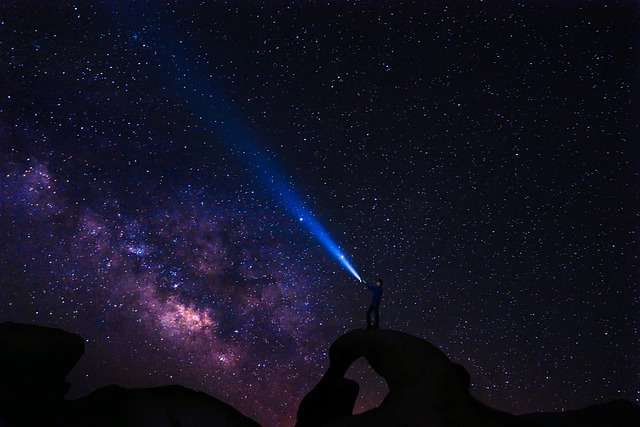

### Table Of Contents

* [Introduction](#introduction)
* [General Purpose Methods](#general_purpose_methods)

## Introduction

The objective of this assignment is to implement and apply various machine learning algorithms to a chosen classification task. The assignment includes the implementation and application of the following algorithms: Principal Component Analysis, Least Squares, Logistic Regression, K Nearest Neighbors, Naïve Bayes, Multilayer Perceptron, and K-Means. Each algorithm serves a specific purpose, ranging from dimensionality reduction to classification and clustering. The results obtained from these implementations will provide insights into the performance of each algorithm in the context of the chosen classification task. After developing the algorithms, comparisons are made with ready-made implementations.

## Imports

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from scipy.stats import multivariate_normal
from statistics import mode

import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import TensorDataset
import torch.nn.functional as F

## Fetch Data

### Context

In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.

### Load the Star Classification Dataset

> The dataset consists of 100.000 cases. Therefore, for the sake of simplicity we apply our algorithms on a randomly chosen sample of 20.000 cases. 

In [6]:
star_data = pd.read_csv("../resources/star_classification.csv")

# Set the random seed for reproducibility
seed_value = 42
star_data = star_data.sample(n=20000, random_state=seed_value)
star_data.head(5)

obj_ID     alpha    delta     u       g       r       i       z    run_ID  rerun_ID  cam_col  field_ID  spec_obj_ID  class   redshift   plate   MJD   fiber_ID
75721  1.238e+18   16.957   3.646  23.335  21.951  20.481  19.603  19.131   7712      301       6        442     4.855e+18   GALAXY  5.062e-01  4312   55511     495  
80184  1.238e+18  240.063   6.134  17.860  16.792  16.430  16.309  16.259   3894      301       1        243     2.449e+18     STAR  3.448e-04  2175   54612     348  
19864  1.238e+18   30.887   1.189  18.189  16.895  16.422  16.246  16.185   7717      301       1        536     8.255e+18     STAR  4.085e-06  7332   56683     943  
76699  1.238e+18  247.594  10.888  25.000  21.712  21.471  21.305  21.291   5323      301       1        134     4.578e+18     STAR -2.915e-04  4066   55444     326  
92991  1.238e+18   18.896  -5.261  23.766  21.797  20.695  20.234  19.975   7881      301       3        148     8.910e+18     STAR -1.362e-04  7914   57331     363

### Content


The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

Here is a description of the features and the <h8 style="color:Purple;">class<h8>:

<table>
<thead>
<tr><th>Variable Name </th><th>Variable Description </th></tr>
</thead>
<tr><td>obj_ID</td><td>Object Identifier, the unique value that identifies the object in the image catalog used by the CAS</td></tr>
<tr><td>alpha</td><td>Right Ascension angle (at J2000 epoch)</td></tr>
<tr><td>delta</td><td>Declination angle (at J2000 epoch)</td></tr>
<tr><td>u</td><td>Ultraviolet filter in the photometric system</td></tr>
<tr><td>g</td><td>Green filter in the photometric system</td></tr>
<tr><td>r</td><td>Red filter in the photometric system</td></tr>
<tr><td>i</td><td>Near Infrared filter in the photometric system</td></tr>
<tr><td>z</td><td>Infrared filter in the photometric system</td></tr>
<tr><td>run_ID</td><td>Run Number used to identify the specific scan</td></tr>
<tr><td>rereun_ID</td><td>Rerun Number to specify how the image was processed</td></tr>
<tr><td>cam_col</td><td>Camera column to identify the scanline within the run</td></tr>
<tr><td>field_ID</td><td>Field number to identify each field</td></tr>
<tr><td>spec_obj_ID</td><td>Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)</td></tr>
<tr><td><h8 style="color:Purple;">class<h8></td><td>object class (galaxy, star or quasar object)</td></tr>
<tr><td>redshift</td><td>redshift value based on the increase in wavelength</td></tr>
<tr><td>plate</td><td>plate ID, identifies each plate in SDSS</td></tr>
<tr><td>MJD</td><td>Modified Julian Date, used to indicate when a given piece of SDSS data was taken</td></tr>
<tr><td>fiber_ID</td><td>fiber ID that identifies the fiber that pointed the light at the focal plane in each observation</td></tr>
<tbody>
</tbody>
</table>


### Main Task

Our task is to classify each observation. There are 3 classes in total:
* $Galaxy$
* $Star$
* $Quasar\; Object$

Each record belongs to a single class.

### Data Preparation for Stellar Classification  Dataset

Our goal is to discriminate among space observations and classify each observation into its respective category. Consequently, certain features may not directly contribute to the classification task. Hence, the following variables will not be utilized:

* `obj_ID` (Object Identifier): While it uniquely identifies an object, it doesn't convey any more information.

* `alpha` (Right Ascension angle) and `delta` (Declination angle): These are celestial coordinates that indicate the position of an object in the sky. They are more related to the spatial location than the object's class.

* `run_ID`, `rerun_ID`, `cam_col`, `field_ID`: These are identifiers and numbers related to the observational setup. While they are important for organizing and retrieving data, they don't directly convey information about the nature of the observed celestial objects.

* `spec_obj_ID`: As stated above, 2 different observations with the same spec_obj_ID must share the output class. This means that there is a strong dependence between the spec_obj_ID and the output class. Our objective is to focus on the instrinsic characteristics of the celestial objects so we choose not to take into account this variable.

* `plate`: This may only be relevant for tracking the observational setup and it should contribute to the object's class.

* `MJD` (Modified Julian Date): It represents the time of observation and is unrelated to the intrinsic properties used for classification.

* `fiber_ID`: While important for identifying the specific fiber used in spectroscopy, it should not contribute to the classification.

> These variables might still be useful for other types of analyses, but for our classification task, the focus is on features that directly reflect the intrinsic properties of the celestial objects being classified (e.g., photometric measurements, redshift, etc.).

In [7]:
columns_to_drop = ["obj_ID", "spec_obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "plate", "MJD", "fiber_ID", "alpha", "delta"]
star_data = star_data.drop(columns=columns_to_drop)

# split initial data into train and test (20% examples for test)
X_train, X_test, y_train_lab, y_test_lab = train_test_split(star_data[['u', 'g', 'r', 'i', 'z', 'redshift']], 
                                                    star_data['class'], 
                                                    test_size=0.2, random_state=42)

# split rest of the train data into train and dev (10% examples for dev)
X_train, X_dev, y_train_lab, y_dev_lab = train_test_split(X_train, y_train_lab, 
                                                  test_size=0.1, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(np.array(X_train))
X_dev = scaler.fit_transform(np.array(X_dev))
X_test = scaler.fit_transform(np.array(X_test))

y_train_lab = np.array(y_train_lab)
y_dev_lab = np.array(y_dev_lab)
y_test_lab = np.array(y_test_lab)

# Convert the y values to integer classes
values = list(np.unique(star_data['class']))
y_convert = lambda x : values.index(x)

y_train = np.array(list(map(y_convert, y_train_lab))).astype(int)
y_test = np.array(list(map(y_convert, y_test_lab))).astype(int)
y_dev = np.array(list(map(y_convert, y_dev_lab))).astype(int)

### Data Visualization

#### Visual representation of the distribution of numerical variables in the dataset

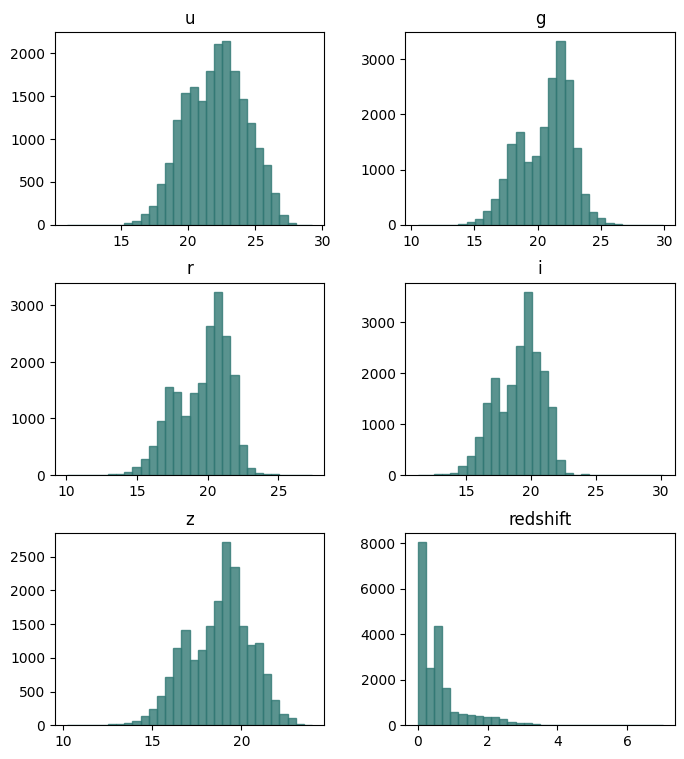

In [47]:
_ = star_data.hist(figsize=(8, 9), bins=30, color="#317873", alpha=0.8, grid=False, edgecolor="#317873")

#### Visual overview of relationships and distributions in the dataset, using a distinct color for each class

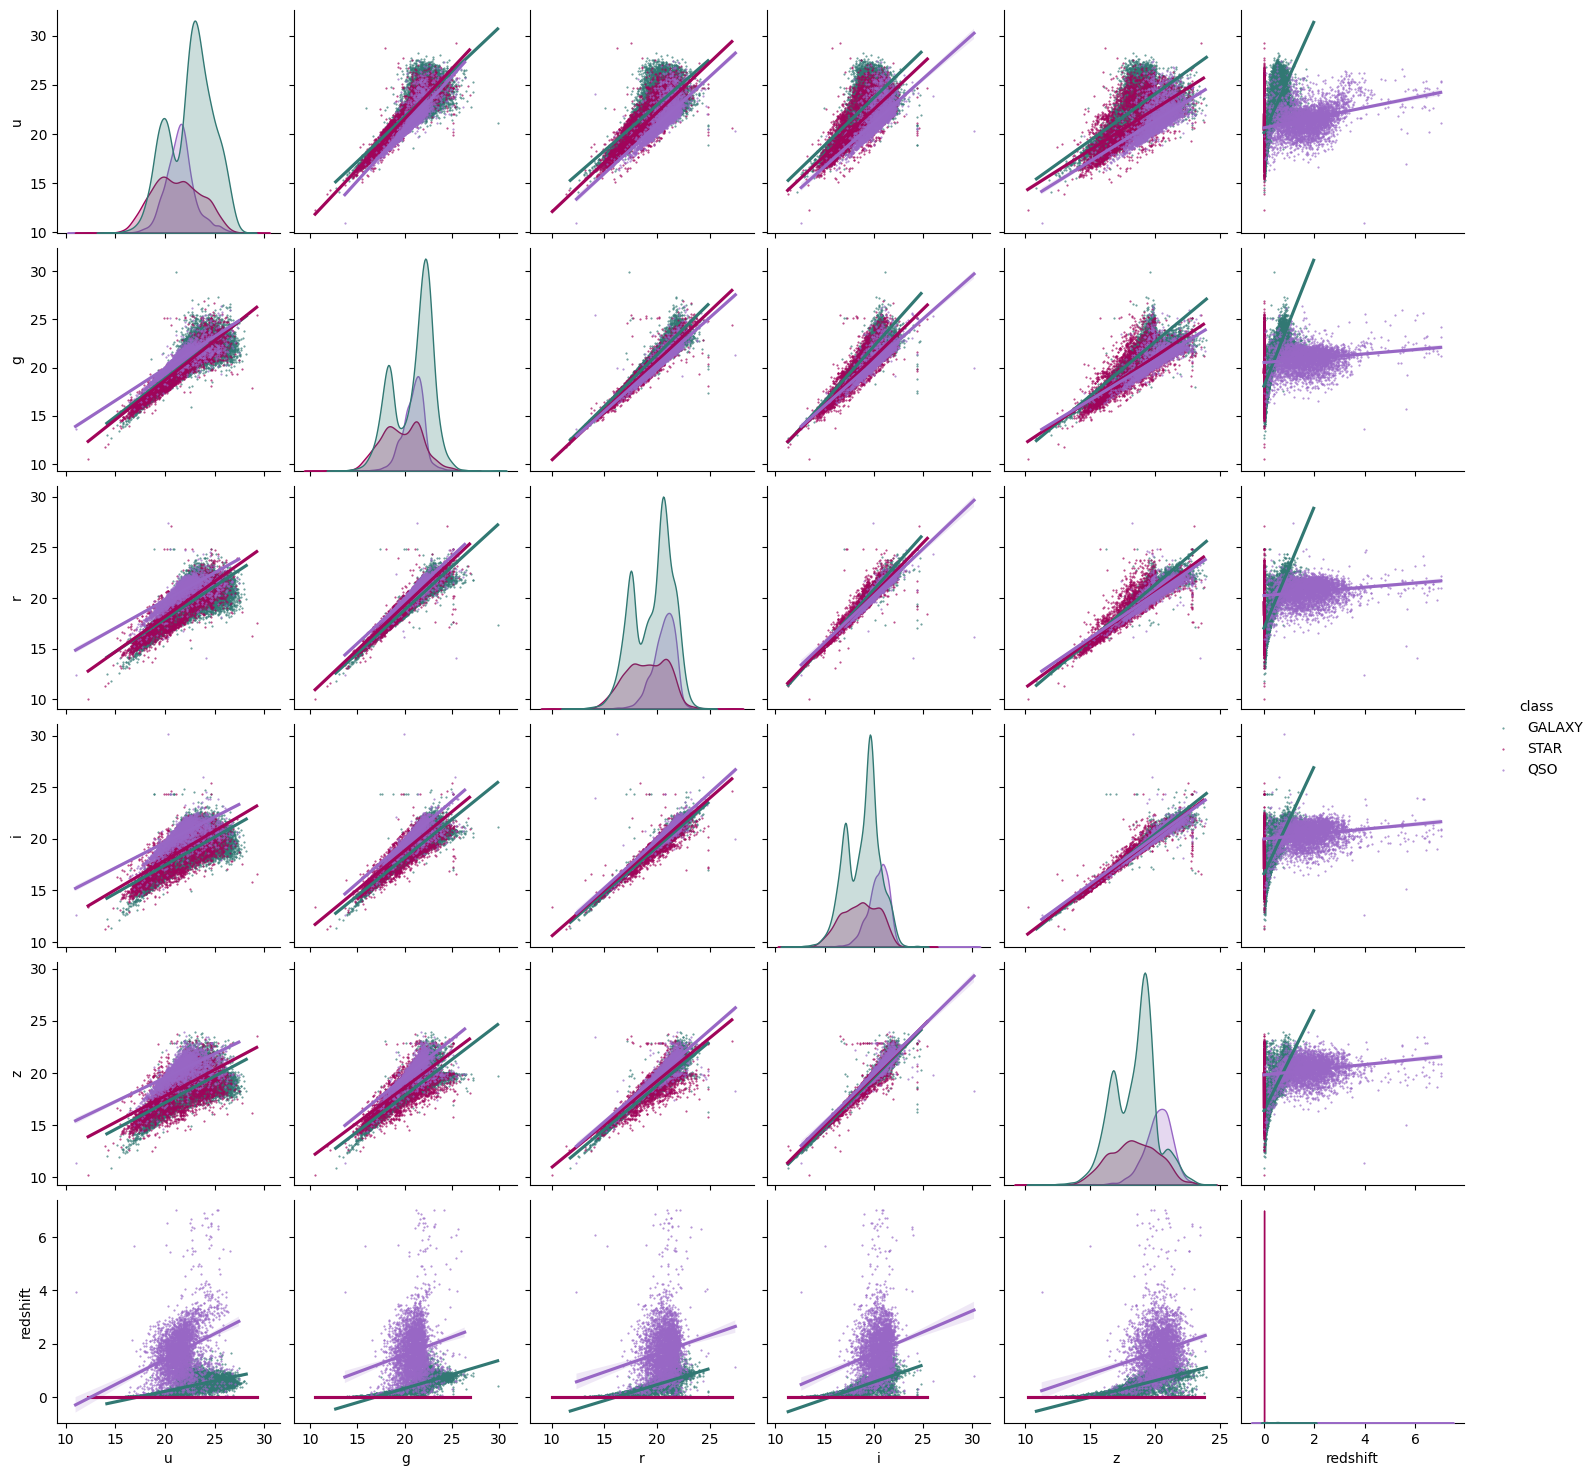

In [41]:
_ = sns.pairplot(star_data, kind="reg", diag_kind="kde",
                 plot_kws={'scatter_kws': {'s': 0.25}},
                 hue="class", palette=["#317873", "#A1045A", "#9867C5"])

#### Visual representation of the correlation coefficients between pairs of variables

- The color intensity and shading convey the strength and direction of the correlations.

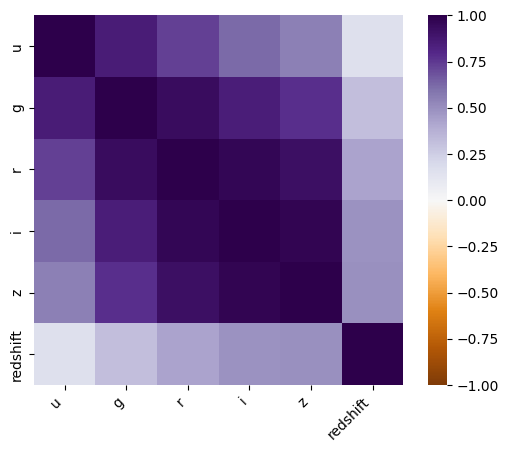

In [42]:
correlation_matrix = star_data.corr(numeric_only=True)

_ = ax = sns.heatmap(
    correlation_matrix,
    vmin=-1, vmax=1, center=0,
    cmap='PuOr',
    square=True
)
_ = ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## General Purpose Methods <a id="general_purpose_methods"></a>

### Distance

In [4]:
class Distance:
    @staticmethod
    def squared_euclidean_distance(X,y):
        # Tile the vector y to create a matrix with the same number 
        # of rows as X and the same number of columns as y
        y = np.tile(y, (X.shape[0], 1))
        
        # Calculate the squared Euclidean distance between each row of x and y
        squared_distance = np.square(X - y).sum(axis=1)
        
        return squared_distance

    @staticmethod
    def euclidean_distance(X, y):
        squared_distance = Distance.squared_euclidean_distance(X,y)
        
        # Take the square root to get the Euclidean distance
        distance = np.sqrt(squared_distance)
    
        return distance

### Curves

In [56]:
class Curve:
    @staticmethod
    def cross_validation_cost_evolution_curve(caption, costs, label=None):
        # Select best hyperparameter
        param = np.argmin(costs) + 1

        # Plot the evolution of the validation error with respect to the best hyperparameter
        if label != None:
            plt.plot(range(1, len(costs)+1), costs * 100, marker='o', color='crimson', label=label)
        else:
            plt.plot(range(1, len(costs)+1), costs * 100, marker='o', color='crimson')
            
        plt.title('K-fold cross validation error evolution')
        plt.ylabel('Average Validation Error %')
        plt.xlabel(caption)
        plt.legend()
        plt.show()
        return param
    
    @staticmethod
    def accuracy_evolution_curve(caption, accuracies, label=None):
        # Select best hyperparameter
        param = np.argmax(accuracies) + 1

        # Plot the evolution of the validation error with respect to the best hyperparameter
        if label != None:
            plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='#3B7A57', label=label)
        else:
            plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='#3B7A57')
            
        plt.title('Accuracy evolution')
        plt.ylabel('Accuracy')
        plt.xlabel(caption)
        plt.legend()
        plt.show()
        return param
    
    @staticmethod
    def cross_entropy_loss_curve(train_losses, dev_losses=None):
        # Plot the evolution of the cross entropy loss
        plt.plot(range(1, len(train_losses)+1), train_losses, marker='.', color='crimson', label='Train set')
        
        if (dev_losses != None):
            plt.plot(range(1, len(dev_losses)+1), dev_losses, marker='.', color='darkslateblue', label='Validation/Development set')
            
        plt.suptitle('Cross entropy loss evolution', y=1.03)
        plt.title(r'$L(\hat y, y) = -\frac{1}{N} \sum_{i=1}^N {\sum_{k=1}^K{y_{i,k} \log(\hat y_{i,k})}}$')
        plt.ylabel('Cross entropy loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
    @staticmethod
    def pca_scree_plot(eigvals):
        labels = [f"PC{i}" for i in range(1, len(eigvals)+1)]
        
        plt.bar(labels, eigvals, color=['#9867C5']*3, width=0.5)
        plt.plot(labels, np.cumsum(eigvals), c='#A1045A', label='Cumulative Explained Variance')
        plt.legend(loc='upper left')
        plt.xlabel('Component')
        plt.ylabel('Explained Variance (eigenvalues)')
        plt.title('Scree plot')
        
        plt.show()
        
    @staticmethod
    def pca_cumulative_var_plot(eigvals):
        labels = [f"PC{i}" for i in range(1, len(eigvals)+1)]
        
        plt.plot(labels, np.cumsum(eigvals)/sum(eigvals)*100, marker='.', color="#317873")
        plt.ylim(0, 105)
        plt.axhline(y=85, color='#A1045A', linestyle='--')
        plt.ylabel("Proportion of Variance (%)")
        plt.xlabel("Components")
        plt.title('Cumulative proportion of Variance')

        plt.show()
        
    @staticmethod
    def biplot(projection, eigvecs, labels):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        x = projection[:, 0]
        y = projection[:, 1]
        n = eigvecs.shape[1]
        
        scale_x = 1 / (np.max(x) - np.min(x))
        scale_y = 1 / (np.max(y) - np.min(y))

        # Draw scatterplot
        ax.scatter(x*scale_x, y*scale_y, c='#317873', marker='o', label='Data Points', alpha=0.5)
    
        # Draw vectors
        for i in range(n):
            ax.arrow(0, 0, eigvecs[0, i], eigvecs[1, i],
                     color='#A1045A', alpha=0.5, label=labels[i], head_width=0.025, head_length=0.025)
            
            ax.text(eigvecs[0, i]*1.1, eigvecs[1, i]*1.1, labels[i], 
                    color='#A1045A', ha='center', va='center')
        
        plt.title('2D Biplot')
        
        # Set axis limits and labels 
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

        plt.legend()
        plt.show()
        
    @staticmethod
    def pca_scatterplot(projection, class_labels):
        X_data_df = pd.DataFrame()
        X_data_df['PC1'] = projection[:, 0]
        X_data_df['PC2'] = projection[:, 1]
        X_data_df['class'] = np.concatenate((y_train_lab, y_dev_lab, y_test_lab))

        sns.set_style("ticks")
        
        sns.lmplot(
            x='PC1', 
            y='PC2', 
            data=X_data_df, 
            hue='class', 
            fit_reg=False, 
            legend=True,
            palette=["#A1045A", "#317873", "#9867C5"],
            scatter_kws={'alpha': 0.5, 's': 2}
            )
        
        plt.title('2D PCA Scatterplot')
        plt.show()
    
    @staticmethod
    def EM_alg_cost_evolution_curve(caption, costs):
        total_iterations = len(costs)//2

        # Plot the evolution of the cost function
        for i in range(2*total_iterations-1):
            # Alternate the marker color for costs calculated after an expectation step (even position) 
            # or a maximization step (odd position)
            color = 'darkslateblue' if i % 2 == 0 else 'crimson'
            label = 'After Expectation Step' if i == 0 else 'After Maximization Step' if i == 1 else ''
            plt.plot([i, i+1], [costs[i], costs[i+1]], marker='o', mfc=color, mec=color, ms='7', ls=':', color='black', label=label)
        last_point = 2*total_iterations-1
        plt.plot(last_point, costs[last_point], marker='o', mfc='crimson', mec='crimson', ms='7')

        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.suptitle(caption, y=1.03)
        plt.title(r'Cost function: $\frac{1}{2}\sum_{i=1}^{N} ||\mathbf{x}_{i} - \mathbf{\hat\mu}_{\hat y_{i}}||^{2}$')
        plt.grid(True)
        plt.legend()

        iterations_ticks = [val for i in range(1, total_iterations + 1) for val in ['', i]]
        plt.xticks(range(2*total_iterations), iterations_ticks)
        
        plt.show()

        # Construct reporting table
        data = []

        for i in range(len(costs)):
            iter = str(i//2)+'a' if i%2==0 else str(i//2)+'b'  # Increasing index for every 2 rows
            step = 'E-step' if i % 2 == 0 else 'M-step'
            cost = costs[i]
            data.append({'Iteration': iter, 'Step': step, 'Cost': cost})

        cost_evolution = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True).set_index('Iteration')

        return cost_evolution
        

### Reporting Tables

In [25]:
class Report:
    @staticmethod
    def gaussian_naive_bayes_parameters(caption, priors, means, covariance_matrix, num_classes, num_features):
        print(caption,"- Priors")
        priors_df = pd.DataFrame(priors.reshape(1, -1), columns=[f'Class_{i}' for i in range(num_classes)])
        display(priors_df)

        print(caption," - Means")
        means_df = pd.DataFrame(means, columns=[f'Feature_{i}' for i in range(num_features)], index=[f'Class_{i}' for i in range(num_classes)])
        display(means_df)

        print(caption," - Covariance Matrix per class")
        for covariance in covariance_matrix:
            covariance_df = pd.DataFrame(covariance, columns=[f'Feature_{i}' for i in range(num_features)], index=[f'Feature_{i}' for i in range(num_features)])
            display(covariance_df)
            
    @staticmethod
    def pca_eigvecs_eigvals(caption, eigvals, eigvecs, num_components, num_features):
        print(caption,"- Eigenvalues (explained variance)")
        eigvals_df = pd.DataFrame(eigvals, columns=[f'Lambda_{i}' for i in range(num_components)])
        display(eigvals_df)
        
        print(caption,"- Eigenvectors")
        eigvecs_df = pd.DataFrame(eigvecs, columns=[f'Feature_{i}' for i in range(num_features)])
        display(eigvecs_df)

## KNN Classification

### Custom kNN Classifier

Below, we implement the well-known kNN algorithm. Note that the Euclidean distance is used as the distance metric for measuring the distance between test set examples and train set examples. Next, two functions are included for finding the best value for the hyperparameter ($k$):

1. Cross Validation Method (`k_fold_cross_validation`):
This method performs cross-validation to find the best value for the hyperparameter $k$. It sets the error each time as the average validation error (across all folds in which the train set is divided each time). Finally, it returns the value of $k$ that resulted in the smallest error.

2. Accuracy-based Validation Method (`accuracy_based_validation`):
This method returns the first value of $k$ that provides the best accuracy on the validation data.

In [10]:
class kNN:
    def __init__(self, k):
        # k nearest neighbors hyperparameter
        self.k = k

        # X_train: n*m matrix (n examples, m features)
        # X[i] = [xi1, xi2, ..., xim] for i=1 to n
        self.X_train = None
        
        # y_train: n*1 vector (class of each example)
        # y[i] = class of X[i]  for i=1 to n
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        Ntest = X_test.shape[0]
        predicted_classes = list()

        for test_example_idx in range(Ntest):
            # Calculate the distance for all train examples
            d = Distance.euclidean_distance(self.X_train, X_test[test_example_idx,:])

            # Return the indices of the K closest instances
            k_closest = np.argsort(d)[:self.k]

            # Find the classes of the k closest instances
            y = self.y_train[k_closest]

            # mode: returns the most frequent (majority vote)
            predicted_classes.append(mode(y))

        return np.array(predicted_classes)

In [11]:
def k_fold_cross_validation(K, numFolds, X, y):
    """
    Perform k-fold cross-validation for kNN.

    Parameters:
    - K: Number of nearest neighbors to test.
    - numFolds: Number of folds for cross-validation.
    - X: Training data features.
    - y: Labels for the training data.

    Returns:
    - best_k: Best k value based on cross-validation.
    """

    N = X.shape[0]
    np.random.seed(10)
    perm = np.random.permutation(N)
    X = X[perm]
    y = y[perm]

    chunk_size = int(N / numFolds)
    split_indices = np.arange(chunk_size, chunk_size * numFolds, chunk_size)

    if chunk_size * numFolds < N:
        split_indices[-1] = N - 1
    else:
        last_chunk = chunk_size

    Xfolds = np.vsplit(X, split_indices)
    yfolds = np.hsplit(y, split_indices)

    errors = np.zeros((K, numFolds))

    for k in tqdm(range(1, K + 1)):
        for j in range(numFolds):
            X_train = np.vstack([Xfolds[i] for i in range(len(Xfolds)) if i != j])
            y_train = np.hstack([yfolds[i] for i in range(len(yfolds)) if i != j])
            X_test = Xfolds[j]

            knn = kNN(k)
            knn.fit(X_train, y_train)
            y_test = knn.predict(X_test)

            # Compute the percent misclassified data points
            errors[k - 1, j] = np.count_nonzero(y_test != yfolds[j]) / X_test.shape[0]
            print("kNN for k = {}, fold # {}, error = {} ".format(k, j, errors[k - 1, j]))

    val = errors.sum(axis=1) / numFolds

    best_k = Curve.cross_validation_cost_evolution_curve("k Nearest Neighbours", val)
    
    print('Smallest average error:', val[best_k - 1])
    print('Best k:', best_k)

    return best_k

In [12]:
def accuracy_based_validation(K, X_train, y_train, X_dev, y_dev):
  """
  Perform accuracy-based validation for the kNN algorithm.

  Parameters:
  - K: Number of nearest neighbors to test.
  - X_train: Training data features.
  - y_train: Labels for the training data.
  - X_dev: Development data features for validation.
  - y_dev: Labels for the development data.

  Returns:
  - best_k: The value of k that achieved the highest accuracy on the development data.
  """
    
  accuracies = np.zeros(K)

  for k in tqdm(range(1, K + 1)):
    knn = kNN(k)  # knn object with current k
    knn.fit(X_train, y_train) # fit with current k in the training data

    predictions = knn.predict(X_dev) # predict with current k using the development data
    accuracy = accuracy_score(y_dev, predictions) # count accuracy
    accuracies[k - 1] = accuracy
    
    print('Accuracy for k={0}: {1}'.format(k, accuracy))
    
  best_k = Curve.accuracy_evolution_curve("k Nearest Neighbours", accuracies)
    
  print('Best dev accuracy:', accuracies[best_k - 1])
  print('Best k:', best_k)

  return best_k

### Training & Testing

#### Optimal value of the hyperparameter $k$

Below we find the optimal value of the hyperparameter $k$ in the range [1, 10] -using both functions defined previously (`k_fold_cross_validation` and `accuracy_based_validation`)- and present our results for each value of $k$.

- `k_fold_cross_validation`

  0%|          | 0/10 [00:00<?, ?it/s]

kNN for k = 1, fold # 0, error = 0.058333333333333334 
kNN for k = 1, fold # 1, error = 0.04097222222222222 
kNN for k = 1, fold # 2, error = 0.06458333333333334 
kNN for k = 1, fold # 3, error = 0.06041666666666667 
kNN for k = 1, fold # 4, error = 0.06041666666666667 
kNN for k = 1, fold # 5, error = 0.058333333333333334 
kNN for k = 1, fold # 6, error = 0.044444444444444446 
kNN for k = 1, fold # 7, error = 0.05694444444444444 
kNN for k = 1, fold # 8, error = 0.059027777777777776 


 10%|█         | 1/10 [00:17<02:33, 17.05s/it]

kNN for k = 1, fold # 9, error = 0.05694444444444444 
kNN for k = 2, fold # 0, error = 0.058333333333333334 
kNN for k = 2, fold # 1, error = 0.04097222222222222 
kNN for k = 2, fold # 2, error = 0.06458333333333334 
kNN for k = 2, fold # 3, error = 0.06041666666666667 
kNN for k = 2, fold # 4, error = 0.06041666666666667 
kNN for k = 2, fold # 5, error = 0.058333333333333334 
kNN for k = 2, fold # 6, error = 0.044444444444444446 
kNN for k = 2, fold # 7, error = 0.05694444444444444 
kNN for k = 2, fold # 8, error = 0.059027777777777776 


 20%|██        | 2/10 [00:32<02:10, 16.35s/it]

kNN for k = 2, fold # 9, error = 0.05694444444444444 
kNN for k = 3, fold # 0, error = 0.049305555555555554 
kNN for k = 3, fold # 1, error = 0.034722222222222224 
kNN for k = 3, fold # 2, error = 0.05347222222222222 
kNN for k = 3, fold # 3, error = 0.04791666666666667 
kNN for k = 3, fold # 4, error = 0.043055555555555555 
kNN for k = 3, fold # 5, error = 0.050694444444444445 
kNN for k = 3, fold # 6, error = 0.04027777777777778 
kNN for k = 3, fold # 7, error = 0.052083333333333336 
kNN for k = 3, fold # 8, error = 0.04375 


 30%|███       | 3/10 [00:48<01:52, 16.06s/it]

kNN for k = 3, fold # 9, error = 0.05416666666666667 
kNN for k = 4, fold # 0, error = 0.04791666666666667 
kNN for k = 4, fold # 1, error = 0.034027777777777775 
kNN for k = 4, fold # 2, error = 0.05486111111111111 
kNN for k = 4, fold # 3, error = 0.05 
kNN for k = 4, fold # 4, error = 0.04722222222222222 
kNN for k = 4, fold # 5, error = 0.04861111111111111 
kNN for k = 4, fold # 6, error = 0.03888888888888889 
kNN for k = 4, fold # 7, error = 0.049305555555555554 
kNN for k = 4, fold # 8, error = 0.044444444444444446 


 40%|████      | 4/10 [01:04<01:36, 16.10s/it]

kNN for k = 4, fold # 9, error = 0.05416666666666667 
kNN for k = 5, fold # 0, error = 0.050694444444444445 
kNN for k = 5, fold # 1, error = 0.03819444444444445 
kNN for k = 5, fold # 2, error = 0.05486111111111111 
kNN for k = 5, fold # 3, error = 0.04722222222222222 
kNN for k = 5, fold # 4, error = 0.04791666666666667 
kNN for k = 5, fold # 5, error = 0.05277777777777778 
kNN for k = 5, fold # 6, error = 0.04375 
kNN for k = 5, fold # 7, error = 0.05347222222222222 
kNN for k = 5, fold # 8, error = 0.04791666666666667 


 50%|█████     | 5/10 [01:22<01:22, 16.58s/it]

kNN for k = 5, fold # 9, error = 0.05694444444444444 
kNN for k = 6, fold # 0, error = 0.04861111111111111 
kNN for k = 6, fold # 1, error = 0.04027777777777778 
kNN for k = 6, fold # 2, error = 0.05555555555555555 
kNN for k = 6, fold # 3, error = 0.049305555555555554 
kNN for k = 6, fold # 4, error = 0.050694444444444445 
kNN for k = 6, fold # 5, error = 0.052083333333333336 
kNN for k = 6, fold # 6, error = 0.04375 
kNN for k = 6, fold # 7, error = 0.05486111111111111 
kNN for k = 6, fold # 8, error = 0.04375 


 60%|██████    | 6/10 [01:39<01:07, 16.88s/it]

kNN for k = 6, fold # 9, error = 0.05347222222222222 
kNN for k = 7, fold # 0, error = 0.052083333333333336 
kNN for k = 7, fold # 1, error = 0.04097222222222222 
kNN for k = 7, fold # 2, error = 0.059027777777777776 
kNN for k = 7, fold # 3, error = 0.050694444444444445 
kNN for k = 7, fold # 4, error = 0.05555555555555555 
kNN for k = 7, fold # 5, error = 0.05625 
kNN for k = 7, fold # 6, error = 0.04583333333333333 
kNN for k = 7, fold # 7, error = 0.059722222222222225 
kNN for k = 7, fold # 8, error = 0.04583333333333333 


 70%|███████   | 7/10 [01:56<00:50, 16.82s/it]

kNN for k = 7, fold # 9, error = 0.05625 
kNN for k = 8, fold # 0, error = 0.05 
kNN for k = 8, fold # 1, error = 0.03958333333333333 
kNN for k = 8, fold # 2, error = 0.059722222222222225 
kNN for k = 8, fold # 3, error = 0.050694444444444445 
kNN for k = 8, fold # 4, error = 0.05416666666666667 
kNN for k = 8, fold # 5, error = 0.05347222222222222 
kNN for k = 8, fold # 6, error = 0.04513888888888889 
kNN for k = 8, fold # 7, error = 0.05763888888888889 
kNN for k = 8, fold # 8, error = 0.04375 


 80%|████████  | 8/10 [02:12<00:33, 16.59s/it]

kNN for k = 8, fold # 9, error = 0.05486111111111111 
kNN for k = 9, fold # 0, error = 0.05555555555555555 
kNN for k = 9, fold # 1, error = 0.04236111111111111 
kNN for k = 9, fold # 2, error = 0.06319444444444444 
kNN for k = 9, fold # 3, error = 0.05277777777777778 
kNN for k = 9, fold # 4, error = 0.05486111111111111 
kNN for k = 9, fold # 5, error = 0.058333333333333334 
kNN for k = 9, fold # 6, error = 0.04583333333333333 
kNN for k = 9, fold # 7, error = 0.059722222222222225 
kNN for k = 9, fold # 8, error = 0.04583333333333333 


 90%|█████████ | 9/10 [02:28<00:16, 16.36s/it]

kNN for k = 9, fold # 9, error = 0.059027777777777776 
kNN for k = 10, fold # 0, error = 0.05486111111111111 
kNN for k = 10, fold # 1, error = 0.04375 
kNN for k = 10, fold # 2, error = 0.0625 
kNN for k = 10, fold # 3, error = 0.05416666666666667 
kNN for k = 10, fold # 4, error = 0.05625 
kNN for k = 10, fold # 5, error = 0.05694444444444444 
kNN for k = 10, fold # 6, error = 0.04513888888888889 
kNN for k = 10, fold # 7, error = 0.059722222222222225 
kNN for k = 10, fold # 8, error = 0.044444444444444446 


100%|██████████| 10/10 [02:43<00:00, 16.39s/it]

kNN for k = 10, fold # 9, error = 0.058333333333333334 


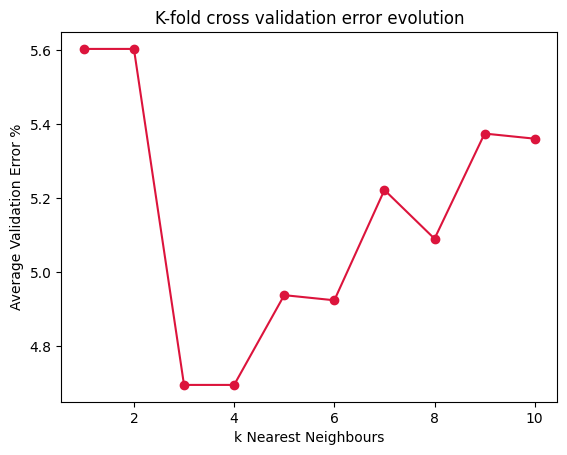

Smallest average error: 0.04694444444444444
Best k: 3


In [13]:
K = 10 # Find the best k hyperparameter in range (1, K)
numFolds = 10 # Number of folds for cross validation

cross_val_best_k = k_fold_cross_validation(K, numFolds, X_train, y_train)

- `accuracy_based_validation`

 10%|█         | 1/10 [00:01<00:17,  1.99s/it]

Accuracy for k=1: 0.9475


 20%|██        | 2/10 [00:04<00:16,  2.01s/it]

Accuracy for k=2: 0.9475


 30%|███       | 3/10 [00:05<00:13,  1.96s/it]

Accuracy for k=3: 0.94625


 40%|████      | 4/10 [00:07<00:11,  1.95s/it]

Accuracy for k=4: 0.951875


 50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

Accuracy for k=5: 0.949375


 60%|██████    | 6/10 [00:12<00:08,  2.18s/it]

Accuracy for k=6: 0.953125


 70%|███████   | 7/10 [00:14<00:06,  2.24s/it]

Accuracy for k=7: 0.95


 80%|████████  | 8/10 [00:16<00:04,  2.18s/it]

Accuracy for k=8: 0.95375


 90%|█████████ | 9/10 [00:18<00:02,  2.14s/it]

Accuracy for k=9: 0.951875


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

Accuracy for k=10: 0.950625


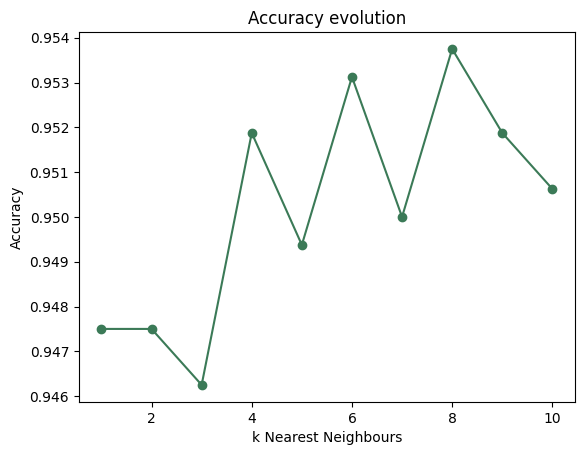

Best dev accuracy: 0.95375
Best k: 8


In [14]:
K = 10
acc_based_best_k = accuracy_based_validation(K, X_train, y_train, X_dev, y_dev)

#### Custom kNN Classifier

- Using the `k_fold_cross_validation` result as $k$


First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set. We anticipate the scores to equal 1.0 for the train set if k equals to 1: 

In [15]:
best_k = cross_val_best_k

# Training kNN Classifier
knn_custom = kNN(best_k) 
knn_custom.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_custom = knn_custom.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8546
           1       0.97      0.94      0.95      2711
           2       0.95      0.99      0.97      3143

    accuracy                           0.97     14400
   macro avg       0.97      0.97      0.97     14400
weighted avg       0.97      0.97      0.97     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [16]:
# Using kNN Classifier (test set)
y_custom = knn_custom.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2344
           1       0.96      0.91      0.93       785
           2       0.91      0.97      0.94       871

    accuracy                           0.95      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.95      0.95      0.95      4000



- Using the `accuracy_based_validation` result as $k$

We repeat the process for both the train set and the test set:

In [17]:
best_k = acc_based_best_k

# Training kNN Classifier
knn_custom = kNN(best_k) 
knn_custom.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_custom = knn_custom.predict(X_train)
print(classification_report(y_train, y_custom))

# Using kNN Classifier (test set)
y_custom = knn_custom.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8546
           1       0.97      0.93      0.95      2711
           2       0.93      0.98      0.95      3143

    accuracy                           0.96     14400
   macro avg       0.96      0.96      0.96     14400
weighted avg       0.96      0.96      0.96     14400

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2344
           1       0.96      0.91      0.94       785
           2       0.90      0.98      0.94       871

    accuracy                           0.95      4000
   macro avg       0.94      0.95      0.94      4000
weighted avg       0.95      0.95      0.95      4000



We can observe that the result of `k_fold_cross_validation` performs better on the test set (while on the train set both results yield maximum scores, as expected).

#### Scikit-Learn kNN Classifier

As implied by the last observation, the result of `k_fold_cross_validation` performs better and hence we will use it to train the Scikit-Learn's algorithm.

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [18]:
best_k = cross_val_best_k

# Training kNN Classifier
knn_scikit = KNeighborsClassifier(n_neighbors=best_k) 
knn_scikit.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_scikit = knn_scikit.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8546
           1       0.97      0.94      0.95      2711
           2       0.95      0.99      0.97      3143

    accuracy                           0.97     14400
   macro avg       0.97      0.97      0.97     14400
weighted avg       0.97      0.97      0.97     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [19]:
# Using kNN Classifier (test set)
y_scikit = knn_scikit.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2344
           1       0.96      0.91      0.93       785
           2       0.91      0.97      0.94       871

    accuracy                           0.95      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.95      0.95      0.95      4000



####  Observations

TEXT HERE

## K-means Clustering

Below, we implement the well-known k-means clustering algorithm, an E-M algorithm. Note that the squared Euclidean distance is used as the distance metric during the expectation step.
Regarding the cantroid initialization, there are two well known methods:

1. <b>Random data points</b>: In this approach, $k$ random data points are selected from the dataset and used as the initial centroids.

2. <b>K-means++</b>: As spreading out the initial centroids is thought to be a worthy goal, k-means++ pursues this by assigning the first centroid to the location of a randomly selected data point, and then choosing the subsequent centroids from the remaining data points based on a probability proportional to the squared distance away from a given point's nearest existing centroid.

[Centroid initialization](https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html)

In our implementation we initialize the centroids using the first method.

### Custom k-means

In [20]:
class kMeans:
    def __init__(self, k, max_iters):
        # k = number of clusters
        self.k = k
        # define the maximum number of iterations
        self.max_iters = max_iters
        # the centroids for all labels
        self.centroids = None

    @staticmethod
    def cost_function(X, c, labels): 
        return 0.5*sum(Distance.squared_euclidean_distance(X[i].reshape((1,X[i].shape[0])), c[labels[i]]) for i in range(X.shape[0]))
    
    def fit(self, X):
        # Choose k random points of data as centroids
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[indices]

        costs = list()

        for _ in range(self.max_iters):
            # Expectation step
            labels = self.predict(X)  # Assign each data point to the nearest centroid
            costs.append(self.cost_function(X, self.centroids, labels).item()) # Calculate the cost 

            # Maximization step
            new_centroids = np.array([np.mean(X[labels == label], axis=0) for label in range(self.k)])
            costs.append(self.cost_function(X, new_centroids, labels).item()) # Calculate the new cost
            
            # If the algorithm has converged, then stop
            if np.all(self.centroids == new_centroids):
                break
                
            self.centroids = new_centroids

        iters = len(costs)//2
        return costs, iters

    def predict(self, X):
        # Assign each data point to the nearest centroid 
        distances = np.array([Distance.squared_euclidean_distance(self.centroids, x) for x in X])
        labels = np.argmin(distances, axis=1)

        return labels

### Training & Testing

💡For evaluating the algorithm's performance, it is crucial to note that the cluster labels assigned by KMeans may not necessarily align with the true class labels. Therefore, other evaluation metrics should be employed, that take into account whether observations that normally belong to the same class are indeed found in the same cluster.

✔️We are going to use 3 commonly used clustering performance evaluation metrics (given that the ground truth is known):
1. <b>Adjusted Rand Index</b>: It is a function that measures the similarity of the two assignments, ignoring permutations:
    - $ARI = (RI - Expected_{RI}) / (max(RI) - Expected_{RI})$ <br> where $RI$ = (number of agreeing pairs) / (number of pairs)
    - The score range is [-1, 1]. Lower values indicate different labelings, similar clusterings have a high index and 1 is the perfect match score.

<br>
    
2. <b>Adjusted Mutual Information</b>: It is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance. We will use AMI.
    - Values close to 0 indicate two label assignments that are largely independent, while values close to 1 indicate significant agreement. Further, an AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).

<br>

3. <b>Fowlkes-Mallows Index</b>: It is defined as the geometric mean of the pairwise precision and recall:
    - $FMI = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}$
    - The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

[Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

Lastly, note that the hyperparameter $k$ is set to be equal to the number of classes

#### Custom k-means

We train the algorithm and display the centroids and the evolution of the cost function below:

In [21]:
num_of_classes = len(np.unique(y_train))
max_iters = 100

# Training k-means
k_means_custom = kMeans(num_of_classes, max_iters) 
costs, iters = k_means_custom.fit(X_train)

# Results
print("Results: ")
print("Iterations run: ", iters)
print("Final Cost: ", costs[-1])
print("Centroids: \n", k_means_custom.centroids)

Results: 
Iterations run:  39
Final Cost:  14089.316790844503
Centroids: 
 [[-0.13728291  0.28827281  0.70159612  0.94212496  1.04373985  1.75739569]
 [-1.04142073 -1.21910104 -1.24139569 -1.19700247 -1.14520327 -0.62288349]
 [ 0.68650427  0.65669834  0.53516879  0.42910435  0.36393844 -0.1913929 ]]


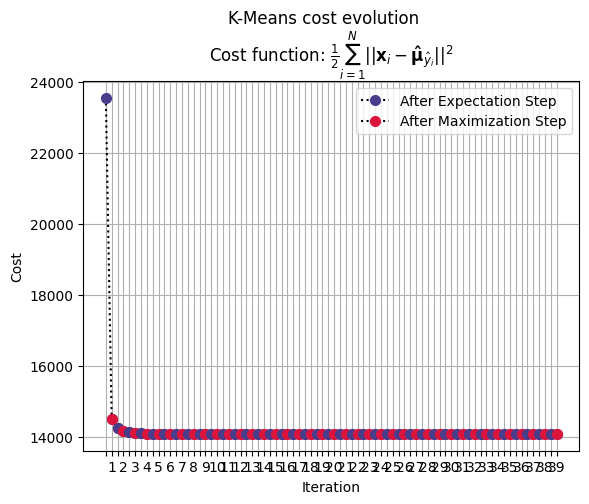

Step     Cost   
Iteration                   
0a         E-step  23546.601
0b         M-step  14495.930
1a         E-step  14247.908
1b         M-step  14164.466
2a         E-step  14131.580
2b         M-step  14115.092
3a         E-step  14106.150
3b         M-step  14100.746
4a         E-step  14097.916
4b         M-step  14096.172
5a         E-step  14094.855
5b         M-step  14093.756
6a         E-step  14093.037
6b         M-step  14092.544
7a         E-step  14092.161
7b         M-step  14091.716
8a         E-step  14091.415
8b         M-step  14091.279
9a         E-step  14091.230
9b         M-step  14091.205
10a        E-step  14091.198
10b        M-step  14091.190
11a        E-step  14091.185
11b        M-step  14091.179
12a        E-step  14091.161
12b        M-step  14091.137
13a        E-step  14091.100
13b        M-step  14091.054
14a        E-step  14091.009
14b        M-step  14090.977
15a        E-step  14090.954
15b        M-step  14090.939
16a        E-step  14090.931
16b        M-step  14090.927
17a        E-step  14090.914
17b        M-step  14090.897
18a        E-step  14090.881
18b        M-step  14090.851
19a        E-step  14090.818
19b        M-step  14090.791
20a        E-step  14090.777
20b        M-step  14090.762
21a        E-step  14090.750
21b        M-step  14090.731
22a        E-step  14090.687
22b        M-step  14090.615
23a        E-step  14090.547
23b        M-step  14090.455
24a        E-step  14090.395
24b        M-step  14090.297
25a        E-step  14090.200
25b        M-step  14090.085
26a        E-step  14089.975
26b        M-step  14089.888
27a        E-step  14089.804
27b        M-step  14089.737
28a        E-step  14089.694
28b        M-step  14089.652
29a        E-step  14089.633
29b        M-step  14089.612
30a        E-step  14089.581
30b        M-step  14089.548
31a        E-step  14089.524
31b        M-step  14089.507
32a        E-step  14089.484
32b        M-step  14089.443
33a        E-step  14089.422
33b        M-step  14089.393
34a        E-step  14089.382
34b        M-step  14089.367
35a        E-step  14089.357
35b        M-step  14089.340
36a        E-step  14089.326
36b        M-step  14089.320
37a        E-step  14089.318
37b        M-step  14089.317
38a        E-step  14089.317
38b        M-step  14089.317

In [22]:
# The evolution of the cost function
report_cost_evolution = Curve.EM_alg_cost_evolution_curve("K-Means cost evolution", costs)
display(report_cost_evolution)

First, the algorithm's performance is evaluated on the train set:

In [23]:
# Using k-means (train set)
y_custom = k_means_custom.predict(X_train)

# Evaluation of clustering performance using appropriate metrics (train set)
ari = metrics.adjusted_rand_score(y_train, y_custom)
ami = metrics.adjusted_mutual_info_score(y_train, y_custom)
fm = metrics.fowlkes_mallows_score(y_train, y_custom)

print("Metrics (train set): ")
print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Metrics (train set): 
Adjusted Rand Index (ARI):  0.2422738368136669
Adjusted Mutual Information (AMI):  0.2919535195544128
Fowlkes-Mallows Index (FM):  0.5562094630514255


Below is a visualization of the learned clusters compared to the actual classes for the train set. Since it is impossible to visualize the clusters for all features simultaneously, the visualization is conducted through pair plots. In other words, the clusters are displayed for two features at a time, and this process is repeated for all combinations of features.

> Note that the colors used for each class/cluster may not allign as the cluster labels assigned by KMeans may not necessarily align with the true class labels.

In [24]:
X_train_df = df = pd.DataFrame(data=X_train, columns=['u', 'g', 'r', 'i', 'z', 'redshift'])
X_train_df['class'] = y_train

# Create pair plots colored by actual class
g = sns.pairplot(X_train_df, diag_kind=False, hue='class', palette=["#317873", "#A1045A", "#9867C5"], height=2.5)

# Create pair plots colored by learned cluster
X_train_df['class'] = y_custom
g = sns.pairplot(X_train_df, diag_kind=False, hue='class', palette=["#317873", "#A1045A", "#9867C5"], height=2.5)
g.map_lower(sns.kdeplot, levels=1, color=".2")
g.map_upper(sns.kdeplot, levels=1, color=".2")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000255CD63D240> (for post_execute):


KeyboardInterrupt: 

Now, the algorithm's performance is evaluated on the test set:

In [26]:
# Using k-means (test set)
y_custom = k_means_custom.predict(X_test)

# Evaluation of clustering performance using appropriate metrics (test set)
ari = metrics.adjusted_rand_score(y_test, y_custom)
ami = metrics.adjusted_mutual_info_score(y_test, y_custom)
fm = metrics.fowlkes_mallows_score(y_test, y_custom)

print("Metrics (test set): ")
print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Metrics (test set): 
Adjusted Rand Index (ARI):  0.2712626890485098
Adjusted Mutual Information (AMI):  0.32823978524249814
Fowlkes-Mallows Index (FM):  0.5700394930550985


Below is a visualization of the learned clusters compared to the actual classes for the train set. Since it is impossible to visualize the clusters for all features simultaneously, the visualization is conducted through pair plots. In other words, the clusters are displayed for two features at a time, and this process is repeated for all combinations of features.

> Note that the colors used for each class/cluster may not allign as the cluster labels assigned by KMeans may not necessarily align with the true class labels.

KeyboardInterrupt: 

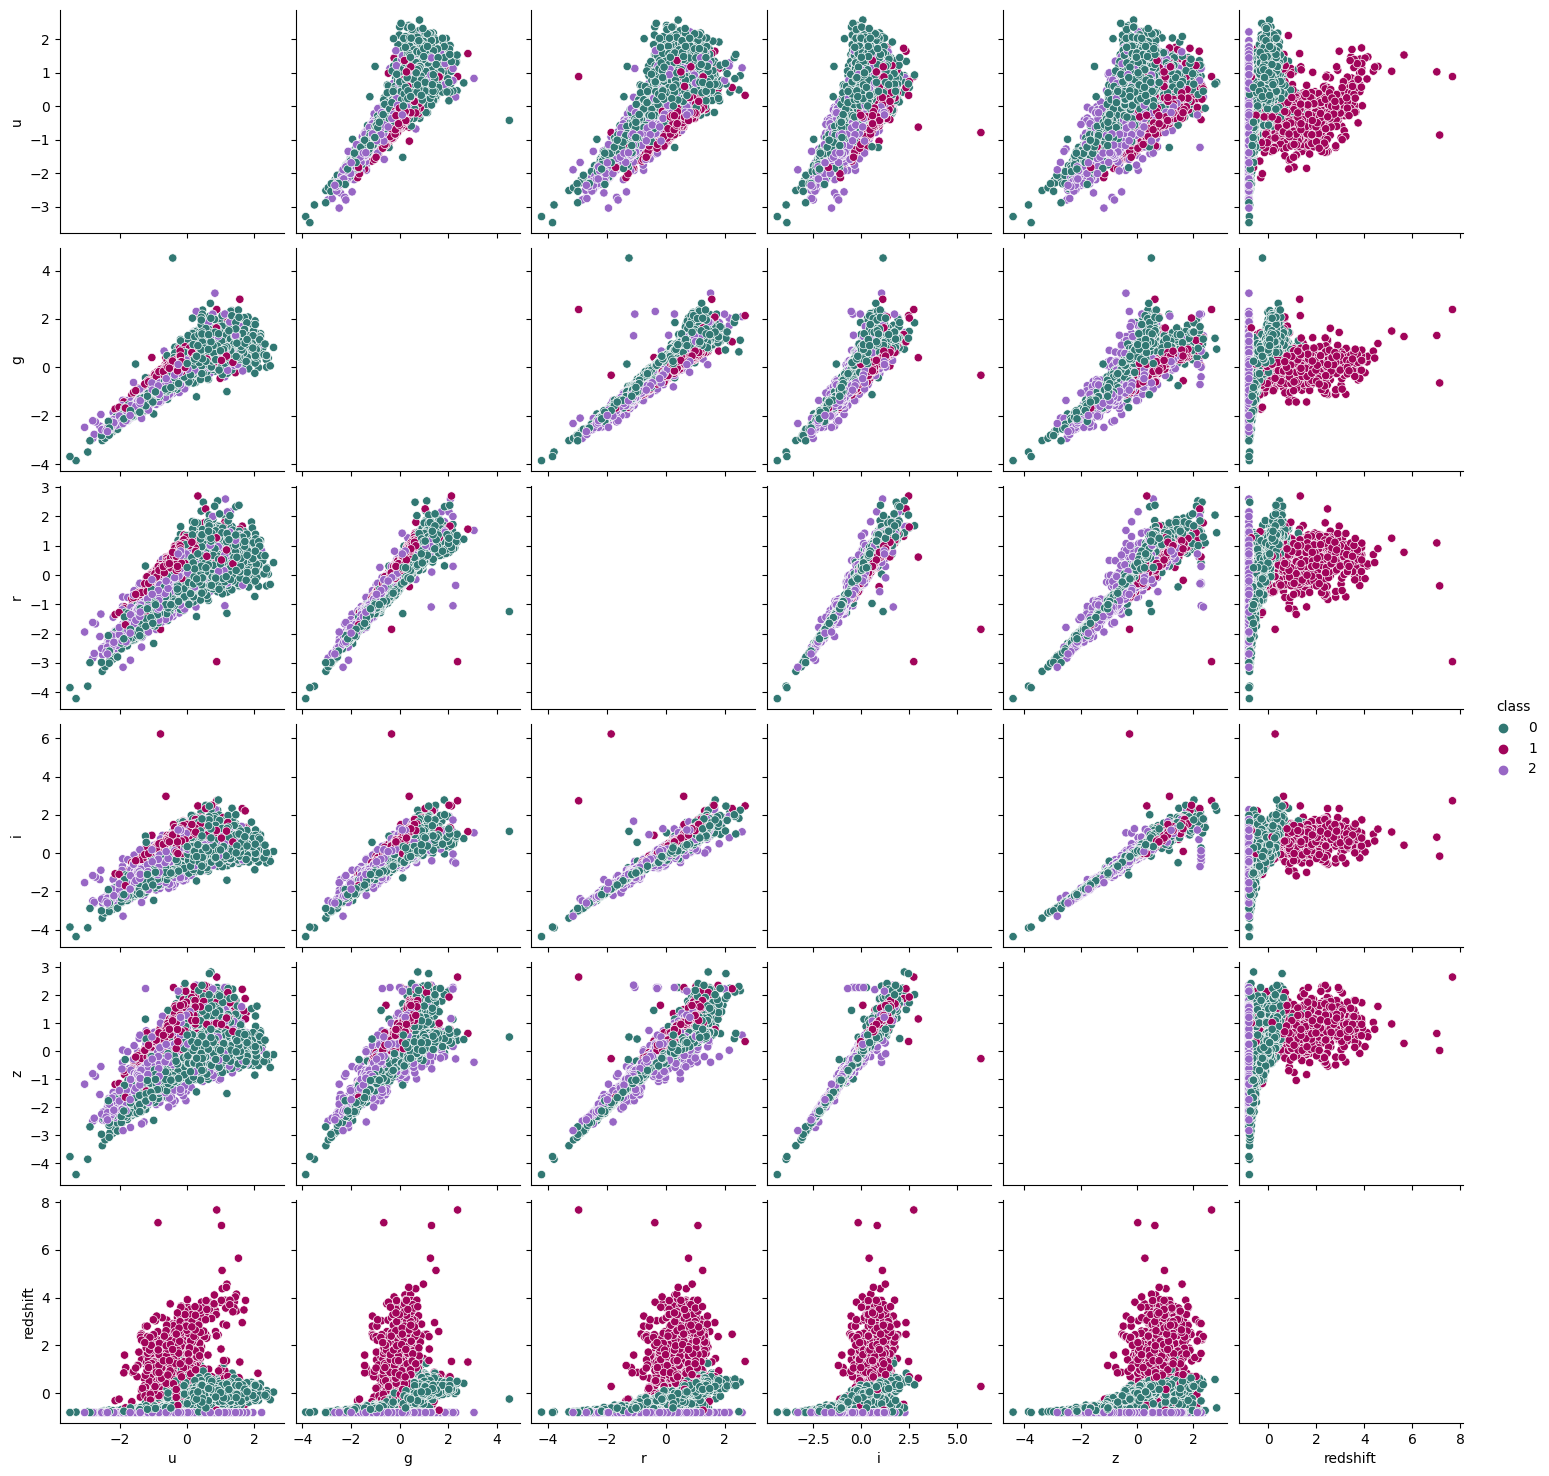

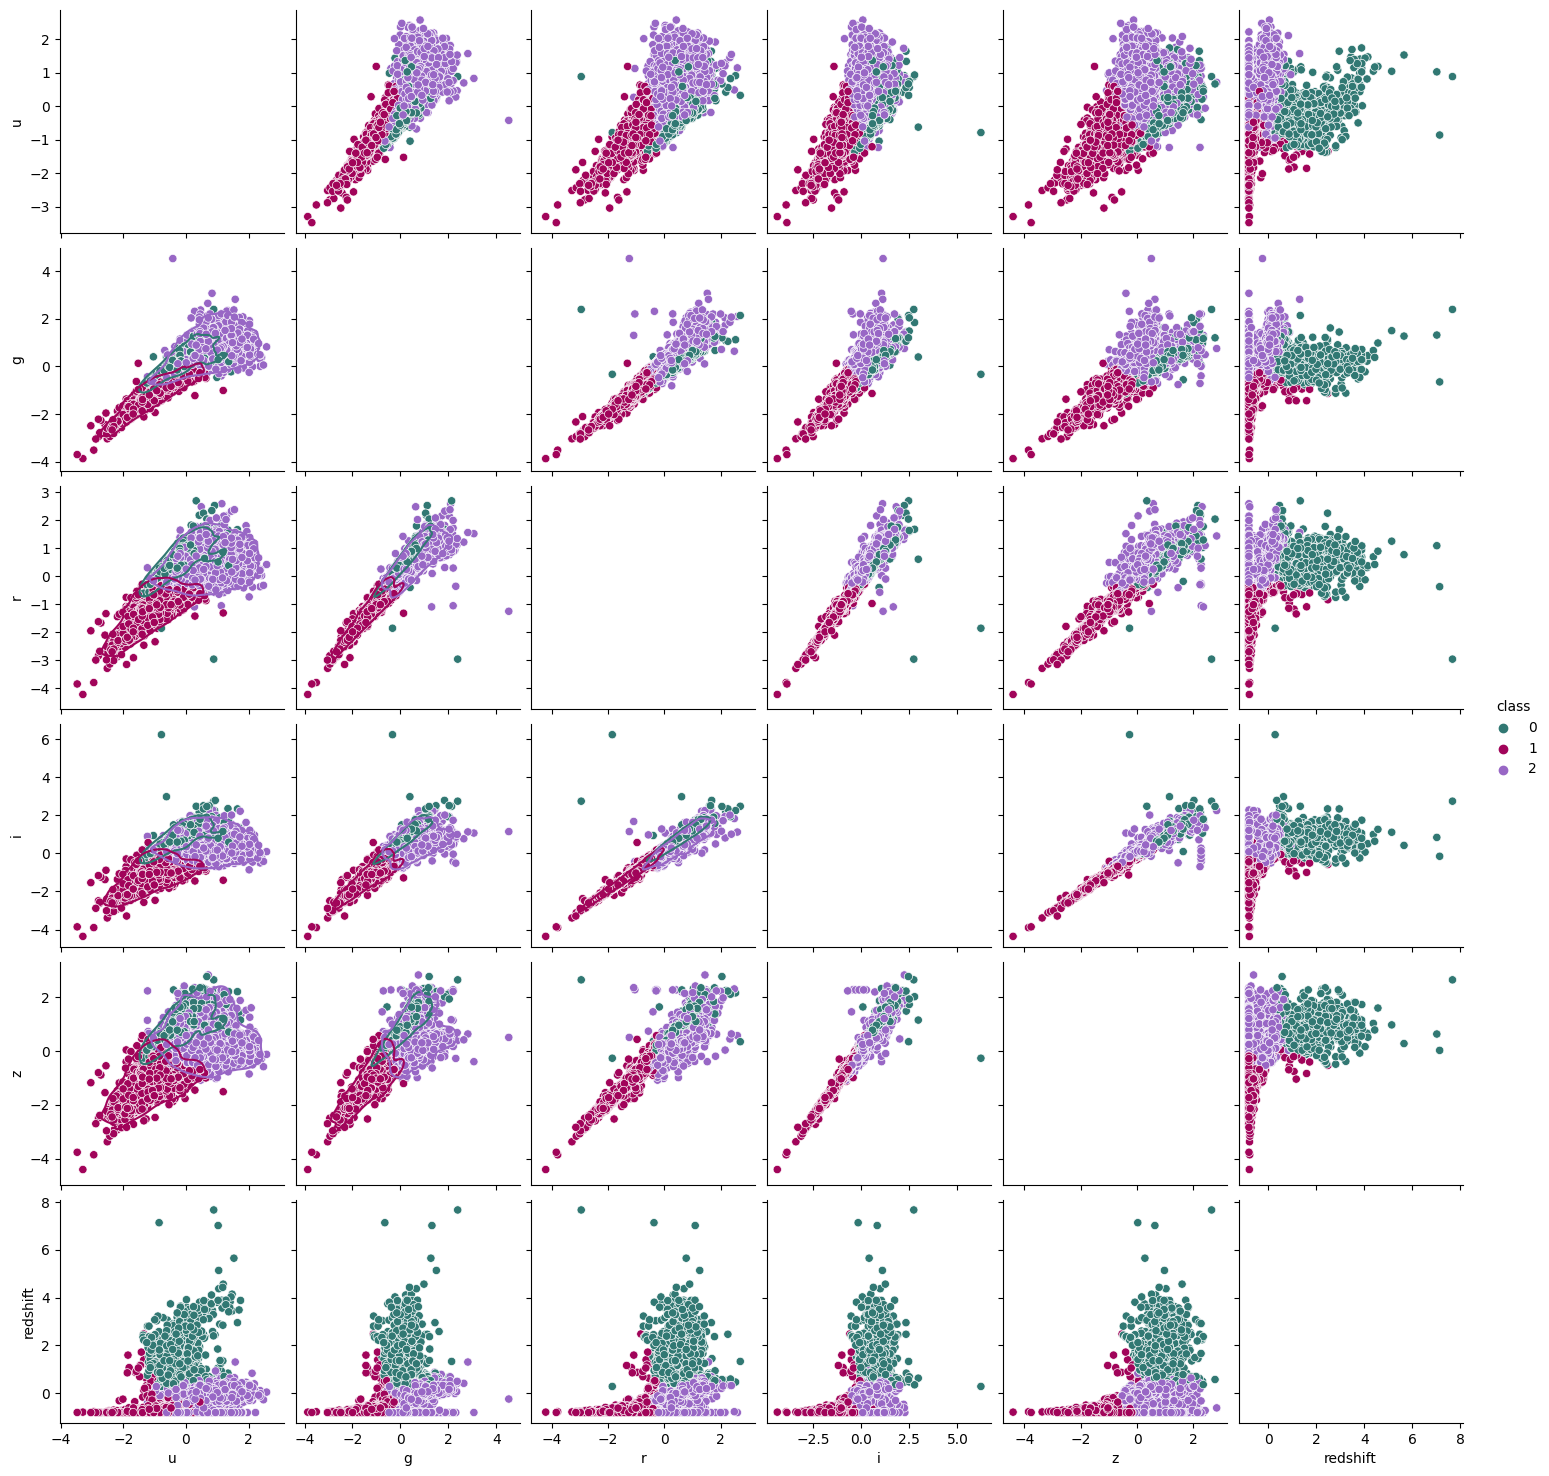

In [28]:
X_test_df = df = pd.DataFrame(data=X_test, columns=['u', 'g', 'r', 'i', 'z', 'redshift'])
X_test_df['class'] = y_test

# Create pair plots colored by actual class
g = sns.pairplot(X_test_df, diag_kind=False, hue='class', palette=["#317873", "#A1045A", "#9867C5"], height=2.5)

# Create pair plots colored by learned cluster
X_test_df['class'] = y_custom
g = sns.pairplot(X_test_df, diag_kind=False, hue='class', palette=["#317873", "#A1045A", "#9867C5"], height=2.5)
g.map_lower(sns.kdeplot, levels=1, color=".2")
g.map_upper(sns.kdeplot, levels=1, color=".2")

#### Scikit-learn k-means

We set the centroid initialization method to be "random" in Scikit-Learn's implementation as well, for comparison purposes. 

We display the centroids and the final value of the cost function below:

In [29]:
# Training k-means
k_means_scikit = KMeans(n_clusters=num_of_classes, init="random")
k_means_scikit.fit(X_train)

# Results
print("Results: ")
print("Iterations run: ", k_means_scikit.n_iter_)
print("Final Cost: ", 1/2 * k_means_scikit.inertia_)    # inertia does not include an 1/2 factor as we did in our implementation, so we need to multiply it to be able to compare the 2 costs
print("Centroids: \n", k_means_scikit.cluster_centers_)
  


c:\Users\alvio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Results: 
Iterations run:  9
Final Cost:  14089.462215981854
Centroids: 
 [[ 0.68756396  0.65456245  0.53106238  0.42421687  0.35852414 -0.19467537]
 [-1.04229325 -1.21985146 -1.2421026  -1.1977354  -1.14592203 -0.62292418]
 [-0.12960073  0.29840744  0.70989505  0.94798824  1.04890664  1.73810323]]


First, the algorithm's performance is evaluated on the train set. For the sake of brevity and because we believe it will not add anything significant to the analysis, we do not display the pair plots for the Scikit-learn's implementation.

In [30]:
# Using k-means
y_scikit = k_means_scikit.predict(X_train)

# Evaluate clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_train, y_scikit)
ami = metrics.adjusted_mutual_info_score(y_train, y_scikit)
fm = metrics.fowlkes_mallows_score(y_train, y_scikit)

print("Metrics: ")
print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Metrics: 
Adjusted Rand Index (ARI):  0.24068280420421254
Adjusted Mutual Information (AMI):  0.2898769441903521
Fowlkes-Mallows Index (FM):  0.5547010800232188


Now, the algorithm's performance is evaluated on the test set. Again, for the sake of brevity, we do not display the pair plots for the Scikit-learn's implementation.

In [31]:
# Using k-means
y_scikit = k_means_scikit.predict(X_test)

# Evaluate clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_test, y_scikit)
ami = metrics.adjusted_mutual_info_score(y_test, y_scikit)
fm = metrics.fowlkes_mallows_score(y_test, y_scikit)

print("Metrics: ")
print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Metrics: 
Adjusted Rand Index (ARI):  0.26979495452765856
Adjusted Mutual Information (AMI):  0.3258333926156934
Fowlkes-Mallows Index (FM):  0.5687650650929358


### Observations

TEXT

## Principal Component Analysis

### Custom PCA (Classic PCA reduction and PCA with SVD)

<h4>Classic PCA reduction:</h4>

1. Normalize the data to have a zero mean:

$$\mathbf{X}_n = \mathbf{X}_n - \mu, \quad n = 1,\ldots,N$$
2. Construct the $d \times d$ covariance matrix:
    $$\mathbf{S} = \frac{1}{N}\sum_{n=1}^{N} x_n x^T$$
    
3. Compute the eigenvalues and eigenvectors of the covariance matrix $\mathbf{S}$
4. Keep the $m$ eigenvectors $\mathbf{U}_{:m}$ corresponding to the $m$ largest eigenvalues ($\rightarrow$ principal components)
5. Project the inputs into the space spanned by the principal components: $\mathbf{projection} = \mathbf{X}_{n} \mathbf{U}_{:k}$

---

<h4>PCA using SVD:</h4>

In a simillar manner, **Singular Value Decomposition (SVD)** can be used to perform PCA. We decompose $\mathbf{X}$ using SVD:
$$ \mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^T$$
 where

- $\mathbf{U}: n \times n$  matrix has as columns the eigenvectors of $\mathbf{X} \mathbf{X^T}$
- $\mathbf{S}: n \times d$ is a diagonal matrix with the singular values of - $\mathbf{X}$ in the diagonal (= square roots of $\mathbf{X} \mathbf{X^T}$ eigenvalues)
- $\mathbf{V}^T: d \times d$  matrix has as columns the eigenvectors of $\mathbf{X^T} \mathbf{X}$

The eigenvalues of the covariance matrix are given by: $$ \lambda_{i} = \frac{S_{i}^2}{N} $$

The upside of SVD is that we calculate the eigenvalues of the covariance matrix without calculating the matrix itself!

In [8]:
class PCACustom:
    def __init__(self, m):
        self.m = m

    def _eigsort(self, A):
        # Compute the eigenvalues and eigenvectors 
        lambdas, U = np.linalg.eig(A)   # The eigenvalues are not necessarily ordered
        
        # Sort in descending order
        ordered_indices = np.argsort(lambdas)[::-1]
        lambdas = lambdas[ordered_indices]
        U = U[:,ordered_indices]
        
        return U, lambdas
    
    def svd_reduction(self, X):
        import scipy
        # Calculate the mean of the input data column-wise (for each feature)
        mu = X.mean(axis=0)
        
        # Normalize the input data, subtracting the mean from each row to center the input data around 0
        normalized_X = X-mu
        
        # SVD of the input matrix
        U, S, V = np.linalg.svd(X, full_matrices=False)

        # Select top m columns of the matrix V (right singular vectors) and the corresponding top m singular values from the array S
        eigvecs = V[:self.m,:]
        eigvals = S[:self.m]*S[:self.m] / X.shape[0]

        # Project the centered data onto the selected eigenvectors
        projection = (normalized_X).dot(eigvecs.T)
      
        return projection, eigvecs, eigvals, mu
    
    
    def classic_reduction(self, X):
        # Calculate the mean of the input data column-wise (for each feature) and convert it to a row vector
        mu = X.mean(axis=0).reshape((1,-1))
        
        # Normalize the input data, subtracting the mean from each row to center the input data around 0
        normalized_X = X-mu

        # Calculate the covariance matrix
        Sigma = (1/X.shape[0]) * normalized_X.T.dot(normalized_X)

        # Compute the eigenvectors and corresponding eigenvalues of the covariance matrix
        U, lambdas = self._eigsort(Sigma)

        # Select top m eigenvectors and corresponding eigenvalues (they are in descending order)
        U = U[:,:self.m]
        lambdas = lambdas[:self.m]

        # Project the centered data onto the selected eigenvectors
        projection = normalized_X.dot(U)
        return projection, U.T, lambdas, mu


To select the number of the components in which we will represent our data, we set a threshold for the proportion of the variance that they explain. The so-called 'explained variance' can be found in the eigenvalues ($\lambda$).

In [9]:
def number_of_pc(eigvals, cumul_var_prop):
    """
    Determine the number of principal components needed to achieve a specified cumulative variance proportion.

    Parameters:
    - eigvals: Eigenvalues of the covariance matrix, sorted in descending order.
    - cumul_var_prop: The target cumulative variance proportion.

    Returns:
    - int: The number of principal components that satisfy the cumulative variance proportion criterion.
    """
    
    eigvals = eigvals.astype('float')
    total_var = np.sum(eigvals)
    cumul_var = 0
    for i in range(len(eigvals)): 
        cumul_var += eigvals[i]
        if cumul_var >= cumul_var_prop * total_var:
            return i

### Execution

#### Optimal value for the hyperparameter $m$ (# of principal components)

Below we find a suitable value for the hyperparameter $m$ in the range $[2, \; \# \: of \: features]$, using the previously defined function`number_of_pc`. In typical scenarios the chosen components should collectively explain at least 85% of the variance:

 $$ \frac{\sum_{i=1}^M \lambda_{i}} {\sum_{i=1}^N \lambda_{i}} \geq 0.85$$

In [65]:
# Perform PCA without dimensionality reduction at first
X_data = np.concatenate((X_train, X_dev, X_test)) # All data
y_data_lab = np.concatenate((y_train_lab, y_dev_lab, y_test_lab))

m = X_train.shape[1]
pca = PCACustom(m)
projection, eigvecs, eigvals, mu = pca.classic_reduction(X_data)

# Find the first number of components that satisfies the criterion
i = number_of_pc(eigvals, 0.85) + 1
print('Criterion is valid when we use ', i, 'components')

Criterion is valid when we use  2 components


#### Visualization 

Visualization of the cumulative proportion of variance (1<sup>st</sup>)and a Scree plot for the explained variance per principal component (2<sup>nd</sup>)

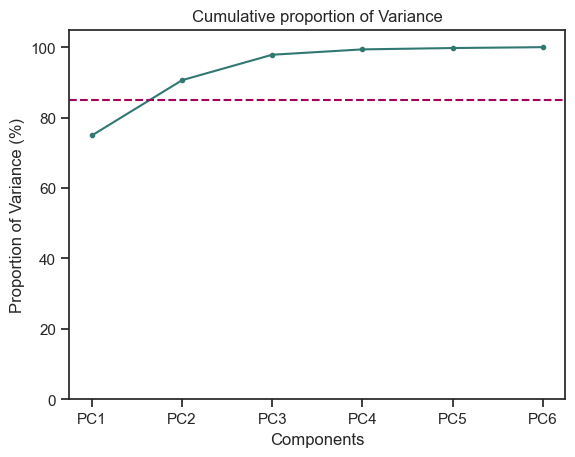

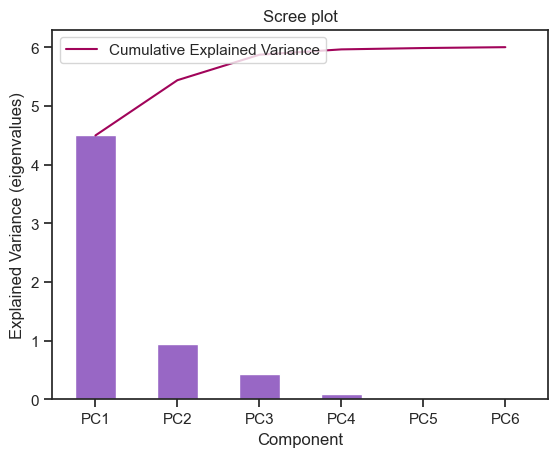

In [36]:
# Visualization
Curve.pca_cumulative_var_plot(eigvals)
Curve.pca_scree_plot(eigvals)

#### Custom PCA with SVD

- Where $m$ is set to the number of components determined above

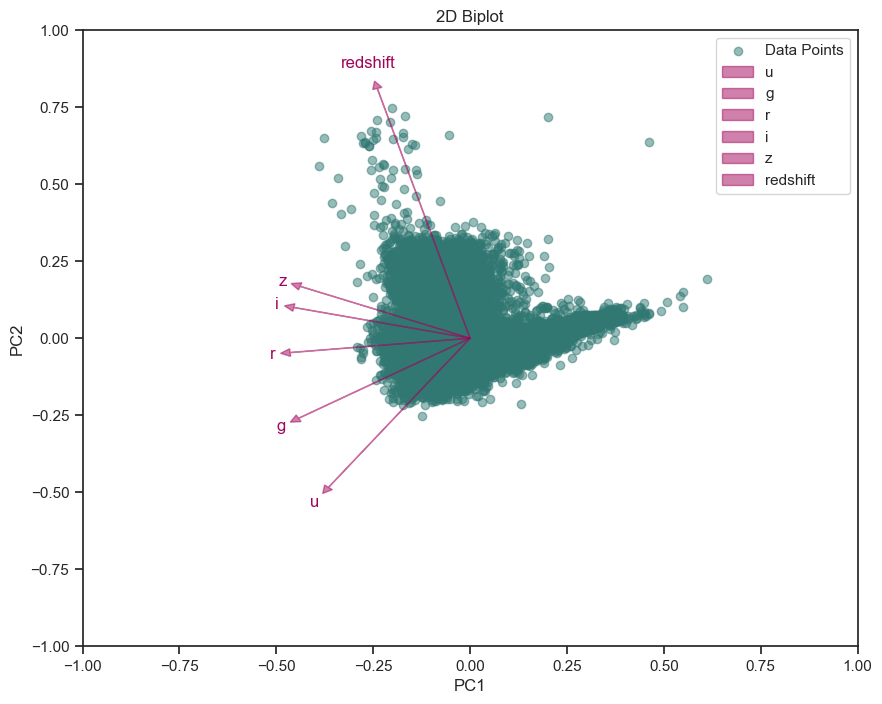

PCA SVD Reduction - Eigenvalues (explained variance)


Lambda_0  Lambda_1
0    4.495     0.942

PCA SVD Reduction - Eigenvectors


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0   -0.365     -0.442     -0.464     -0.454     -0.438     -0.239  
1   -0.484     -0.260     -0.046      0.100      0.169      0.811

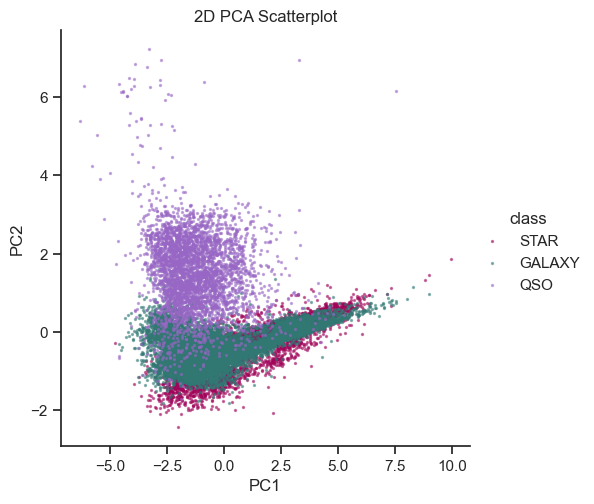

In [66]:
# Perform PCA with the number of components determined above (Using SVD)
m = i
pca = PCACustom(m)
projection, eigvecs, eigvals, mu = pca.svd_reduction(X_data)

# 2D Biplot
Curve.biplot(projection, eigvecs, ['u', 'g', 'r', 'i', 'z', 'redshift'])

# Display the eigen values and eigen vectors
Report.pca_eigvecs_eigvals("PCA SVD Reduction", eigvals.reshape(1,2), eigvecs, num_components=m, num_features=X_train.shape[1])

# 2D Scatterplot
Curve.pca_scatterplot(projection, y_data_lab)

#### Custom Classic PCA Reduction

- Where $m$ is set to the number of components determined above

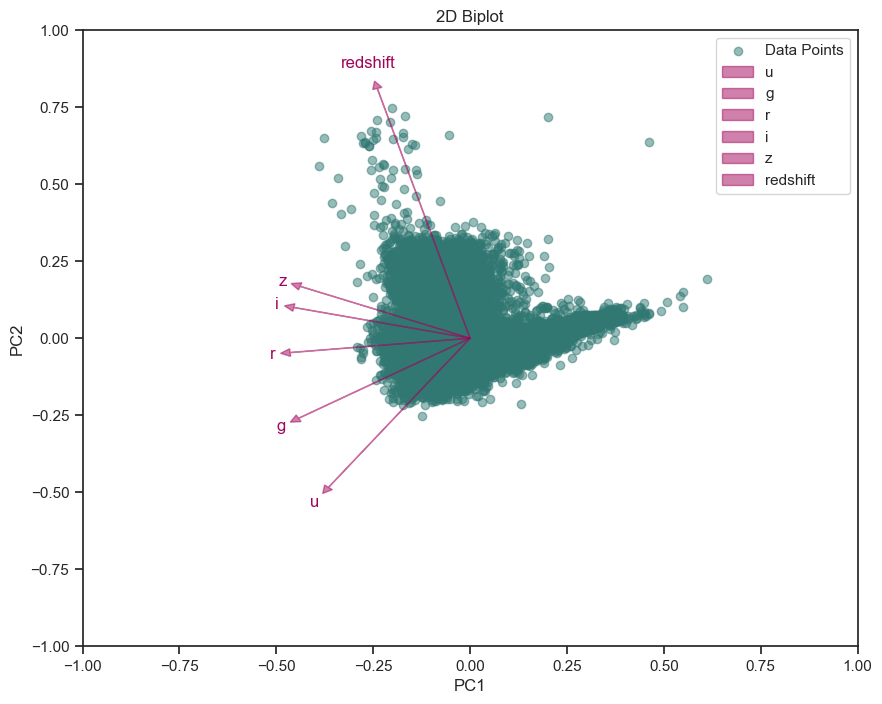

PCA Classic Reduction - Eigenvalues (explained variance)


Lambda_0  Lambda_1
0    4.495     0.942

PCA Classic Reduction - Eigenvectors


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0   -0.365     -0.442     -0.464     -0.454     -0.438     -0.239  
1   -0.484     -0.260     -0.046      0.100      0.169      0.811

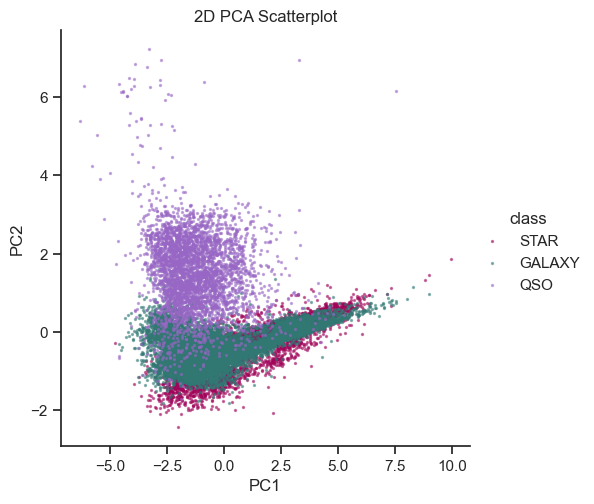

In [67]:
# Perform PCA with the number of components determined earlier (Using Classic reduction)
m = i
pca = PCACustom(m)
projection, eigvecs, eigvals, mu = pca.classic_reduction(X_data)

# 2D Biplot
Curve.biplot(projection, eigvecs, ['u', 'g', 'r', 'i', 'z', 'redshift'])

# Display the eigen values and eigen vectors
Report.pca_eigvecs_eigvals("PCA Classic Reduction", eigvals.reshape(1,2), eigvecs, num_components=m, num_features=X_train.shape[1])

# 2D Scatterplot
Curve.pca_scatterplot(projection, y_data_lab)

#### Scikit-Learn PCA

- Where $m$ is set to the number of components determined above

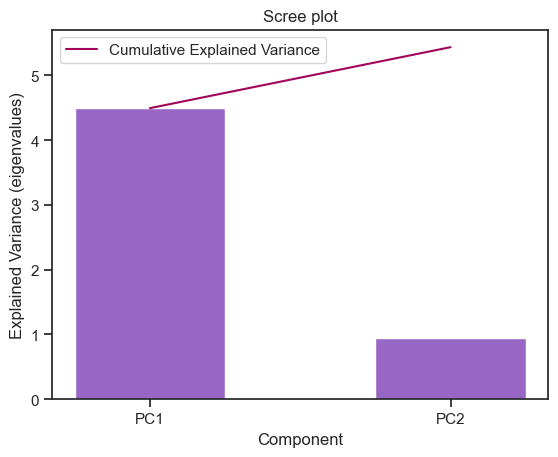

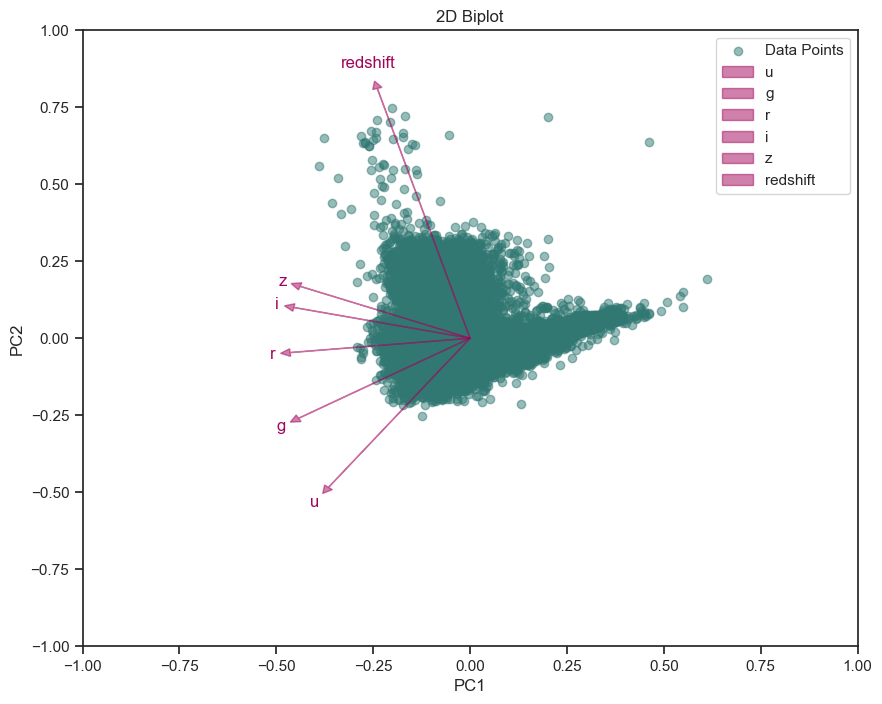

PCA Scikit-Learn SVD Reduction - Eigenvalues (explained variance)


Lambda_0  Lambda_1
0    4.495     0.942

PCA Scikit-Learn SVD Reduction - Eigenvectors


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0   -0.365     -0.442     -0.464     -0.454     -0.438     -0.239  
1   -0.484     -0.260     -0.046      0.100      0.169      0.811

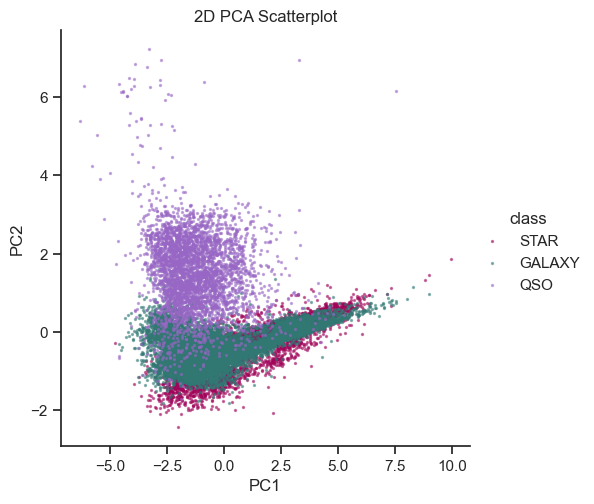

In [69]:
# Fit and transform the data
from sklearn.decomposition import PCA
pca = PCA(n_components=m, svd_solver="full")
projection2 = pca.fit_transform(X_data)

# Access the principal components (eigenvectors) and explained variances
components = pca.components_
explained_variance = pca.explained_variance_

# Scree plot
Curve.pca_scree_plot(explained_variance)

# 2D Biplot
Curve.biplot(projection, components, ['u', 'g', 'r', 'i', 'z', 'redshift'])

# Display the eigen values and eigen vectors
Report.pca_eigvecs_eigvals("PCA Scikit-Learn SVD Reduction", eigvals.reshape(1,2), eigvecs, num_components=m, num_features=X_train.shape[1])

# 2D Scatterplot
Curve.pca_scatterplot(projection2, y_data_lab)

### Observations

TEXT HERE

## Least Squares Classification

Consider a classification problem with  classes, with a 1-of-K binary coding scheme for the target vector t. Each class $C_k$ has its own linear model.

Each class $C_k$ is described by its own linear model so that: $y_k(\mathbf{x})=\mathbf{w}_k^T \mathbf{x} + w_{k0}$ where k=1,...,K, or, using vector notation: $$\mathbf{ y(x) = {\tilde W}^T \tilde x }$$

where $\mathbf{\tilde W}$ is a matrix whose $k^{th}$ column comprises the $D+1$-dimensional vector $ \mathbf {\tilde w}_k = (w_{k0} ; \mathbf{w}_k^T)^T$ and $ \mathbf {\tilde x}$ is the corresponding augmented input vector $(1;\mathbf{x}^T)^T$ with a dummy input $x_0 = 1$. Assign new input $\mathbf x$ to the class $C_k$ if $k=argmax\;y_j (\mathbf x)$. Consider a training data set $\{\mathbf {x}_n, \mathbf {t}_n \}$ where $n=1,...,N$ and define a matrix $\mathbf T$ whose $n^{th}$ row is the vector $\mathbf{t}_n^T$.

The sum-of-squares error function can then be written as:
$E_D(\mathbf{\tilde W}) = \frac{1}{2}Tr((\mathbf{\tilde{X} \tilde{W} - T})^T(\mathbf{\tilde{X} \tilde{W} - T}))$.

➡️  Setting the derrivative w.r.t. $\tilde W$ to zero, and rearranging, we obtain the solution:
$\mathbf {\tilde{W} = (\tilde{X}^T\tilde{X})^{-1}\tilde{X}^TT}$, where $(\tilde{X}^T\tilde{X})^{-1}\tilde{X}^T$ is the pseudo-inverse of $\mathbf{\tilde X}.$

➡️  We then obtain the discriminant function in the form $\mathbf{ y(x) = {\tilde W}^T \tilde x }$ 

<i>Bishop, C. M. (2006). Pattern Recognition and Machine Learning (Chapter 4.1.3: Least Squares for Classification).</i>


- To implement the algorithm described above, during fit we first covert `y_train` to one-hot-vectors (matrix $\mathbf T$) and then learn the weights (matrix $\mathbf W$) using the above formula. Predict is implemented exactly as derscibed.

### Custom Least Squares Classifier

In [38]:
class LeastSquares:
    def __init__(self):
        self.W = None
        self.num_classes = None    
        
    def _one_hot_vector(self, x):
        vector = np.zeros(self.num_classes).astype(int)
        vector[x] = 1
        return vector
        
    def fit(self, X_train, y_train):
        self.num_classes = np.unique(y_train).shape[0]
        
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_train, 0, 1, axis=1)
        
        # T: T[i] = one-hot vector for the class of example i
        T = list(map(self._one_hot_vector, y_train))
        
        # W: W = pseudo_inverse(X) * T
        self.W = np.linalg.pinv(X).dot(T)

    def predict(self, X_test):
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_test, 0, 1, axis=1)
        
        # Y: Y = transpose(W) * transpose(X)
        Y = self.W.T.dot(X.T)

        classes = np.argmax(Y, axis=0)
        
        return classes

### Training & Testing

#### Custom Least Squares Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [39]:
# Training Least Squares Classifier
least_squares = LeastSquares()
least_squares.fit(X_train, y_train)

# Using Least Squares Classifier (train set)
y_custom = least_squares.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      8546
           1       0.90      0.88      0.89      2711
           2       0.78      0.50      0.61      3143

    accuracy                           0.83     14400
   macro avg       0.83      0.77      0.79     14400
weighted avg       0.82      0.83      0.82     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [40]:
# Using Least Squares Classifier (test set)
y_custom = least_squares.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      2344
           1       0.92      0.88      0.90       785
           2       0.78      0.50      0.61       871

    accuracy                           0.83      4000
   macro avg       0.84      0.77      0.79      4000
weighted avg       0.83      0.83      0.82      4000



The weights learned during training (matrix $\mathbf W$) are displayed below:

In [41]:
# Print the weights that were learned during the training
print("Weights learned: \n",least_squares.W)

Weights learned: 
 [[ 0.59347222  0.18826389  0.21826389]
 [ 0.04553457 -0.0744183   0.02888373]
 [ 0.47240637 -0.1445318  -0.32787457]
 [-0.13258261 -0.00300228  0.13558489]
 [-0.21117709  0.11965038  0.09152671]
 [-0.15160854  0.06634677  0.08526177]
 [-0.04706671  0.26275184 -0.21568512]]


#### Scikit-Learn Ridge Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [42]:
# Training Ridge Classifier
scikit_ridge = RidgeClassifier(alpha=0) # alpha=0 means no regularization
scikit_ridge.fit(X_train, y_train)

# Using Ridge Classifier (train set)
y_scikit = scikit_ridge.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      8546
           1       0.90      0.88      0.89      2711
           2       0.78      0.50      0.61      3143

    accuracy                           0.83     14400
   macro avg       0.83      0.77      0.79     14400
weighted avg       0.82      0.83      0.82     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [43]:
# Using Ridge Classifier (test set)
y_scikit = scikit_ridge.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      2344
           1       0.92      0.88      0.90       785
           2       0.78      0.50      0.61       871

    accuracy                           0.83      4000
   macro avg       0.84      0.77      0.79      4000
weighted avg       0.83      0.83      0.82      4000



The weights learned during training are displayed below:

In [44]:
# Print the weights that were learned during the training
print("Weights learned: \n",scikit_ridge.coef_)

Weights learned: 
 [[ 0.09106914  0.94481274 -0.26516521 -0.42235419 -0.30321708 -0.09413343]
 [-0.1488366  -0.28906361 -0.00600456  0.23930077  0.13269354  0.52550367]
 [ 0.05776746 -0.65574913  0.27116978  0.18305342  0.17052354 -0.43137025]]


### Observations

TEXT

## Logistic Regression with Stochastic Gradient Descent


In this section, the Logistic Regression classification algorithm is implemented. Our model is trained using Stochastic Gradient Descent and the loss function used is the Cross-Entropy Loss.

The weight update rule given that the loss function is Cross Entropy Loss, is the following:

$$weights = weights - \eta * gradient$$
where:
- $\eta$: learning rate
- $gradient=outer(example,\; probabilities−one\; hot\; label)$

---

Let's break down the maths behind the weight update rule:

1. <b>The cross-entropy loss for a single training example is given by:</b>
    $$L(\hat y, y) = - \sum_{k=1}^K{y_k}log(\hat y_k)$$
    where:
    - $\hat y_k$: the predicted probability for class $i$ (through $softmax$)
    - $y_k$: the corresponding element of the one-hot encoded true label vector
    - $K$: the classes

2. <b>The softmax activation function is used to convert raw scores (logits) into probabilities:</b>
    $$softmax(\mathbf t)_j = \frac{exp(\mathbf t_j)}{\sum_{k=1}^K{exp(\mathbf t_k)}}$$
    where:
    - $\mathbf t$: the vector of logits
    - $K$: the classes

3. <b> The gradient of Cross-Entropy Loss w.r.t. the weights is:</b>
    $$ \frac{\partial L}{\partial \mathbf W_{ij}} = x_i(\hat y_j - y_j)$$
    Explanation: 
    $$\frac{\partial L}{\partial \mathbf W_{ij}} = - \frac{\partial \sum_{k=1}^K{y_i}log(\hat y_i)}{\partial \mathbf W_{ij}} = - \sum_{k=1}^K{\frac{\partial L}{\partial \hat y_k} \frac{\partial \hat y_k}{\partial t_j} \frac{\partial t_j}{\partial \mathbf W_{ij}}}$$
    - $\frac{\partial L}{\partial \hat y_k} = - \frac{y_k}{\hat y_k}$
    
    - $\frac{\partial \hat y_k}{\partial t_j} = \hat y_k (\delta_{kj} - \hat y_j) ^ {[1]}$, where $\delta_{kj}$ is the Kronecker delta

    - $\frac{\partial t_j}{\partial \mathbf W_{ij}} = x_i$

    Combining these three terms yields $ \frac{\partial L}{\partial \mathbf W_{ij}} = x_i(\hat y_j - y_j)$

    [1]: $\frac{\partial \hat y_k}{\partial t_j}$ is in essence the derivative of the softmax function w.r.t. the logits (as $\hat y_k$ is the estimated probability which is computed using softmax)
    
    - Case 1: $k=j$
    
        $\frac{\partial softmax(t)_k}{\partial t_k} = \frac{exp(t_k)\sum_{i=1}^K{exp(t_i) - exp(t_k)exp(t_k)}}{(\sum_{i=1}^K {exp(t_i)})^2} = \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}} * (1 - \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}}) = softmax(t)_k * (1-softmax(t)_k)$

    - Case 2: $k \neq j$
    
        $\frac{\partial softmax(t)_k}{\partial t_j} = \frac{- exp(t_k)exp(t_j)}{(\sum_{i=1}^K {exp(t_i)})^2} = - \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}} * \frac{exp(t_j)}{\sum_{i=1}^K{exp(t_i)}} = -softmax(t)_k * (1-softmax(t)_j)$

    Overall,

    $$
    \frac{\partial softmax(t)_k}{\partial t_j} =
    \begin{cases}
    softmax(t)_k * (1 - softmax(t)_k), \; if\;  k=j\\
    -softmax(t)_k * softmax(t)_j, \; if\; k \neq j\\
    \end{cases}
    = softmax(t)_k(\delta_{kj} - softmax(t)_j)
    $$

---


Lastly, early stopping is implemented based on the validation accuracy. If the validation accuracy does not improve for a certain number of epochs (20 in this case) (`n_epochs_unchanged`), the training is terminated early, and the weights (`best_weights`) from the epoch (`best_epoch`) with the best accuracy (`best_accuracy` )are retained.

### Custom Logistic Regression Classifier

In [43]:
class LogisticRegressionClassifier():
    def __init__(self, n_iters, learning_rate):
        self.n_iters = n_iters
        self.learning_rate = learning_rate
        self.W = None
    
    @staticmethod
    def _softmax(t):
        return np.exp(t) / np.sum(np.exp(t))  
    
    @staticmethod
    def _one_hot_vector(class_, num_classes):
        one_hot_vec = np.zeros(num_classes)
        one_hot_vec[int(class_)] = 1
        return one_hot_vec
    
    @staticmethod
    def _cross_entropy_loss(y, y_hat):
        return -sum(y * np.log(y_hat))

    def fit(self, X_train, y_train, X_val, y_val):
        num_examples, num_features = X_train.shape
        num_val_examples = X_val.shape[0]
        num_classes = len(np.unique(y_train))

        # insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_train, 0, 1, axis=1) 
        X_val_ext = np.insert(X_val, 0, 1, axis=1)

        # insert y_train array to shuffle examples in for loop
        F = np.insert(X, 0, y_train, axis=1)     

        # initialize the weights W
        self.W = np.zeros((num_features + 1, num_classes))

        best_accuracy = 0
        best_epoch = 0
        n_epochs_unchanged = 0
        
        train_cross_entropy_losses = list()
        val_cross_entropy_losses = list()

        for epoch in tqdm(range(1, self.n_iters+1)):
            
            train_loss = 0
            
            np.random.shuffle(F)  #random permutation of examples
            X = F[:,1:]
            y_train = F[:,0]
            for i in range(num_examples):
                example = X[i]  
                logits = self.W.T.dot(example)
                probabilities = self._softmax(logits)
                one_hot_vec = self._one_hot_vector(y_train[i], num_classes)

                self.W = self.W - self.learning_rate * np.outer(example, probabilities - one_hot_vec)
                # (D,K)                                  (D,K)     #(D,)       (K,)         (K,)
                
                # Update train loss for the current example
                train_loss += self._cross_entropy_loss(one_hot_vec, probabilities)
            
            # Compute validation data loss for all validation examples at once
            val_loss = sum(self._cross_entropy_loss(self._one_hot_vector(y_val[i], num_classes), self._softmax(self.W.T.dot(X_val_ext[i]))) for i in range(len(X_val_ext)))
            
            # Keep track of both losses per epoch
            train_cross_entropy_losses.append(train_loss/num_examples)
            val_cross_entropy_losses.append(val_loss/num_val_examples)
            
            # Early Stopping using accuracy on validation data
            accuracy = accuracy_score(y_val, self.predict(X_val))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch
                best_weights = self.W
                n_epochs_unchanged = 0
            else:
                n_epochs_unchanged += 1

            if n_epochs_unchanged == 20:
                self.W = best_weights
                break  

        print("Best epoch: "+str(best_epoch))
        return train_cross_entropy_losses, val_cross_entropy_losses


    def predict(self, X_test):
        X = np.insert(X_test, 0, 1, axis=1)   #insert 1 in x_vector for w0

        y_pred = list()
        for example in X:
            y_pred.append(np.argmax(self._softmax(self.W.T.dot(example))))

        return np.array(y_pred)


### Training & Testing

We set the learning rate to be 0.01 ($\eta=0.01$) which seems to perform well. Regarding the max iterations, the value is set to $100$, as it was experimentally observed that with the use of early stopping, the iterations/epochs were generally fewer than $100$.

#### Custom Logistic Regression Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [45]:
# Training Logistic Regression Classifier
logistic_regression = LogisticRegressionClassifier(100, 0.01)
train_losses, test_losses = logistic_regression.fit(X_train, y_train, X_dev, y_dev)

# Using Logistic Regression Classifier (train set)
y_custom = logistic_regression.predict(X_train)
print(classification_report(y_train, y_custom))

 80%|████████  | 80/100 [00:15<00:03,  5.16it/s]

Best epoch: 61
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8546
           1       0.94      0.88      0.91      2711
           2       0.94      1.00      0.97      3143

    accuracy                           0.95     14400
   macro avg       0.95      0.94      0.94     14400
weighted avg       0.95      0.95      0.95     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [46]:
# Using Logistic Regression Classifier (test set)
y_custom = logistic_regression.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2344
           1       0.95      0.88      0.92       785
           2       0.89      1.00      0.94       871

    accuracy                           0.94      4000
   macro avg       0.93      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



Finally, the curve of cross-entropy loss evolution is displayed as epochs progress. We expect a decreasing trend in the loss but not necessarily consistently decreasing. This occurs because we are executing stochastic gradient descent, meaning we update the weights according to a single example each time. Thus, the steps do not always move towards the minimum of the total cross entropy loss but rather towards the minimum of $L(\hat y_i, y_i)$ (sometimes it may seem like the algorithm takes random steps as well!).

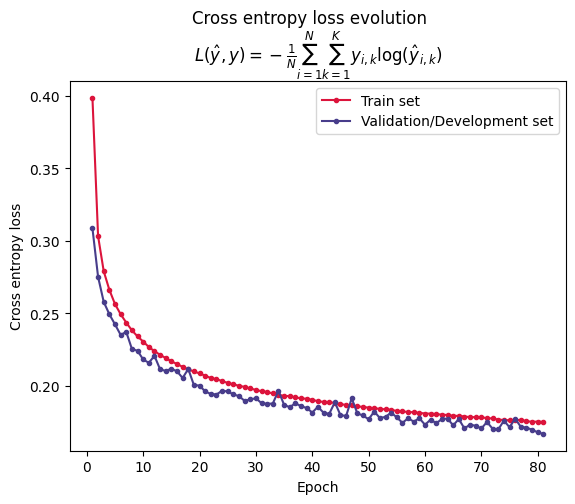

In [47]:
# Display the (total) cross entropy loss evolution curve
Curve.cross_entropy_loss_curve(train_losses, test_losses)

#### Scikit-Learn Logistic Regression Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [48]:
# Training LogisticRegression Classifier
scikit_logistic_regression = LogisticRegression(max_iter=100, penalty=None)
scikit_logistic_regression.fit(X_train, y_train)

# Using LogisticRegression Classifier
y_scikit = scikit_logistic_regression.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8546
           1       0.94      0.88      0.91      2711
           2       0.97      1.00      0.99      3143

    accuracy                           0.96     14400
   macro avg       0.96      0.95      0.95     14400
weighted avg       0.96      0.96      0.96     14400



c:\Users\alvio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [49]:
# Using LogisticRegression Classifier
y_scikit = scikit_logistic_regression.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2344
           1       0.95      0.89      0.92       785
           2       0.95      1.00      0.98       871

    accuracy                           0.96      4000
   macro avg       0.96      0.95      0.95      4000
weighted avg       0.96      0.96      0.96      4000



### Observations

TEXT

## Gaussian Naive Bayes Classifier

### Custom Gaussian Naive Bayes Classifier

Consider a general case where we are in $R^d$. We assume that the population from which our data is sampled follows a normal distribution $N(μ, Σ)$. To apply Naive Bayes in $R^d$, we choose to approximate this distribution with a second distribution $N(m, C)$, where $C$ is a diagonal covariance matrix. The latter implies that we consider independence among the variables, leading to zero covariances (and thus a diagonal covariance matrix $C$ where only $COV(X_i, X_i) = VAR(X_i) \geq 0$, for $i=1,...,d)$.

Let $θ = (μ, Σ)$ and $φ = (m, C)$.

Now, we can approach the distribution $N(μ, Σ)$ in two ways:
1. Choose $φ$ s.t. $KL(θ : φ)$ is minimized
2. Choose $φ$ s.t. $KL(φ : θ)$ is minimized, where $KL$ is the Kullback-Liebler divergence

These approaches lead to the following formulas, respectively:
1. $m = μ$, $C = diag(Σ)$
2. $m = μ$, $C = diag(Λ)^{-1}$, where $Λ$ is the precision matrix (i.e. $Λ = Σ^{-1}$)

In the following implementation we use the first formula.

In [50]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.covariances = None
    
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.priors = {}
        self.means = {}
        self.covariances = {}
        
        for c in self.classes:
            # Separate examples per class 
            class_data = X_train[y_train == c]
            
            # Calculate the prior probability for each class
            self.priors[c] = class_data.shape[0] / X_train.shape[0]

            # Calculate the mean vector for each class: m = [mean(f1), mean(f2),...]
            self.means[c] = np.mean(class_data, axis=0)
            
            # Calculate the covariance vector for each class: C = diag(var(f1), var(f2),...). Note that only the diagonal needs to be stored
            self.covariances[c] = np.var(class_data, axis=0)

    def predict(self, X_test):
        predictions = list()

        for example in X_test:
            class_prob = []
            for c in self.classes:
                # P(c|example) ~ P(c) * P(example|c) = P(c) * P(example|m_c, C_c)
                class_prob.append(self.priors[c] * multivariate_normal.pdf(example, mean = self.means[c], cov=self.covariances[c]))
            predictions.append(self.classes[np.argmax(class_prob)])
        
        return np.array(predictions)

### Training & Testing

#### Custom Gaussian Naive Bayes Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [52]:
# Training Gaussian Naive Bayes Classifier
gaussian_nb = GaussianNaiveBayes()
gaussian_nb.fit(X_train, y_train)

# Using Gaussian Naive Bayes Classifier (train set)
y_custom = gaussian_nb.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      8546
           1       0.77      0.87      0.82      2711
           2       0.98      0.99      0.98      3143

    accuracy                           0.92     14400
   macro avg       0.90      0.93      0.91     14400
weighted avg       0.93      0.92      0.92     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [53]:
# Using Gaussian Naive Bayes Classifier (test set)
y_custom = gaussian_nb.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      2344
           1       0.71      0.89      0.79       785
           2       0.00      0.00      0.00       871

    accuracy                           0.72      4000
   macro avg       0.48      0.60      0.53      4000
weighted avg       0.56      0.72      0.63      4000



The parameters (priors, means and covariance matrix) are displayed below:

In [54]:
# Print the estimated priors (per class), means (per class and feature) and covariances(per class and feature)
custom_priors = np.asarray(list(gaussian_nb.priors.values()))
custom_means = np.asarray(list(gaussian_nb.means.values()))
custom_num_classes = len(gaussian_nb.classes)
custom_covariances = np.array([np.diag(list(gaussian_nb.covariances.values())[i]) for i in range(custom_num_classes)])

Report.gaussian_naive_bayes_parameters("Custom Gaussian Naive Bayes Classifier", custom_priors, custom_means, custom_covariances, custom_num_classes, X_train.shape[1])

Custom Gaussian Naive Bayes Classifier - Priors


Class_0  Class_1  Class_2
0   0.593    0.188    0.218

Custom Gaussian Naive Bayes Classifier  - Means


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Class_0    0.221      0.128     -0.036     -0.136     -0.185     -0.206  
Class_1   -0.251      0.136      0.512      0.740      0.830      1.560  
Class_2   -0.385     -0.465     -0.344     -0.269     -0.213     -0.785

Custom Gaussian Naive Bayes Classifier  - Covariance Matrix per class


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    1.01       0.000      0.000      0.000      0.000      0.000  
Feature_1    0.00       1.072      0.000      0.000      0.000      0.000  
Feature_2    0.00       0.000      1.025      0.000      0.000      0.000  
Feature_3    0.00       0.000      0.000      0.931      0.000      0.000  
Feature_4    0.00       0.000      0.000      0.000      0.879      0.000  
Feature_5    0.00       0.000      0.000      0.000      0.000      0.136

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    0.444      0.000      0.000      0.000      0.000       0.0   
Feature_1    0.000      0.338      0.000      0.000      0.000       0.0   
Feature_2    0.000      0.000      0.358      0.000      0.000       0.0   
Feature_3    0.000      0.000      0.000      0.387      0.000       0.0   
Feature_4    0.000      0.000      0.000      0.000      0.406       0.0   
Feature_5    0.000      0.000      0.000      0.000      0.000       1.6

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    1.116      0.000      0.00       0.000      0.00     0.000e+00
Feature_1    0.000      1.098      0.00       0.000      0.00     0.000e+00
Feature_2    0.000      0.000      1.14       0.000      0.00     0.000e+00
Feature_3    0.000      0.000      0.00       1.121      0.00     0.000e+00
Feature_4    0.000      0.000      0.00       0.000      1.11     0.000e+00
Feature_5    0.000      0.000      0.00       0.000      0.00     4.311e-07

#### Scikit-Learn Gaussian Naive Bayes Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [55]:
# Training GaussianNB Classifier
scikit_gaussian_nb = GaussianNB()
scikit_gaussian_nb.fit(X_train, y_train)

# Using GaussianNB Classifier (train set)
y_scikit = scikit_gaussian_nb.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      8546
           1       0.77      0.87      0.82      2711
           2       0.98      0.99      0.98      3143

    accuracy                           0.92     14400
   macro avg       0.90      0.93      0.91     14400
weighted avg       0.93      0.92      0.92     14400



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [56]:
# Using GaussianNB Classifier (test set)
y_scikit = scikit_gaussian_nb.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      2344
           1       0.71      0.89      0.79       785
           2       0.00      0.00      0.00       871

    accuracy                           0.72      4000
   macro avg       0.48      0.60      0.53      4000
weighted avg       0.56      0.72      0.63      4000



The parameters (priors, means and covariance matrix) are displayed below:

In [57]:
# Print the estimated priors (per class), means (per class and feature) and covariances(per class and feature)
scikit_priors = scikit_gaussian_nb.class_prior_
scikit_means = scikit_gaussian_nb.theta_
scikit_num_classes = len(scikit_gaussian_nb.classes_)
scikit_covariances = np.array([np.diag(scikit_gaussian_nb.var_[i]) for i in range(scikit_num_classes)])
scikit_num_features = scikit_gaussian_nb.n_features_in_

Report.gaussian_naive_bayes_parameters("Scikit-Learn Gaussian Naive Bayes Classifier", scikit_priors, scikit_means, scikit_covariances, scikit_num_classes, scikit_num_features)

Scikit-Learn Gaussian Naive Bayes Classifier - Priors


Class_0  Class_1  Class_2
0   0.593    0.188    0.218

Scikit-Learn Gaussian Naive Bayes Classifier  - Means


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Class_0    0.221      0.128     -0.036     -0.136     -0.185     -0.206  
Class_1   -0.251      0.136      0.512      0.740      0.830      1.560  
Class_2   -0.385     -0.465     -0.344     -0.269     -0.213     -0.785

Scikit-Learn Gaussian Naive Bayes Classifier  - Covariance Matrix per class


Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    1.01       0.000      0.000      0.000      0.000      0.000  
Feature_1    0.00       1.072      0.000      0.000      0.000      0.000  
Feature_2    0.00       0.000      1.025      0.000      0.000      0.000  
Feature_3    0.00       0.000      0.000      0.931      0.000      0.000  
Feature_4    0.00       0.000      0.000      0.000      0.879      0.000  
Feature_5    0.00       0.000      0.000      0.000      0.000      0.136

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    0.444      0.000      0.000      0.000      0.000       0.0   
Feature_1    0.000      0.338      0.000      0.000      0.000       0.0   
Feature_2    0.000      0.000      0.358      0.000      0.000       0.0   
Feature_3    0.000      0.000      0.000      0.387      0.000       0.0   
Feature_4    0.000      0.000      0.000      0.000      0.406       0.0   
Feature_5    0.000      0.000      0.000      0.000      0.000       1.6

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Feature_0    1.116      0.000      0.00       0.000      0.00     0.000e+00
Feature_1    0.000      1.098      0.00       0.000      0.00     0.000e+00
Feature_2    0.000      0.000      1.14       0.000      0.00     0.000e+00
Feature_3    0.000      0.000      0.00       1.121      0.00     0.000e+00
Feature_4    0.000      0.000      0.00       0.000      1.11     0.000e+00
Feature_5    0.000      0.000      0.00       0.000      0.00     4.321e-07

### Observations

TEXT HERE

## Multilayer Perceptron (MLP)

### Custom MLP

In [11]:
gpu_avail = torch.cuda.is_available()
print(f"Using GPU? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Using GPU? False


In [12]:
class MlpModel(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, num_layers=1):
        super().__init__()
        # Initialize the modules we need to build the network
        self.layers = [nn.Linear(num_inputs, num_hidden)]

        for i in range(num_layers):
            self.layers.append(nn.ReLU())
            out_features = num_outputs if i == (num_layers - 1) else num_hidden
            self.layers.append(nn.Linear(num_hidden, out_features=out_features))

        # Define the sequential model
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x)

In [13]:
class MlpClassifier():
    def __init__(self, model, optimizer, loss_module, num_epochs=100, n_epochs_unchanged=5):
        self.model = model
        self.optimizer = optimizer
        self.loss_module = loss_module
        self.num_epochs = num_epochs
        self.n_epochs_unchanged = n_epochs_unchanged

    def train_model(self, data_loader, dev_loader):
        # Set model to train mode
        self.model.train()

        train_cross_entropy_losses = list()
        dev_cross_entropy_losses = list()
        
        best_loss = float('inf')
        early_stopping_counter = 0
        
        # Training loop
        for epoch in tqdm(range(self.num_epochs)):
            train_loss = 0
            
            for data_inputs, data_labels in data_loader:

                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                ## Step 2: Run the model on the input data
                preds = self.model(data_inputs)
                preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = self.loss_module(preds, data_labels.float())
                train_loss += loss.item()

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                self.optimizer.zero_grad()
                loss.backward()

                ## Step 5: Update the parameters
                self.optimizer.step()
            
            # Keep track of both losses per epoch
            train_cross_entropy_losses.append(train_loss/len(data_loader))
            dev_loss, _ = self.eval_model(dev_loader)
            dev_cross_entropy_losses.append(dev_loss)
            
            # Check for early stopping
            if dev_loss < best_loss:
                best_loss = dev_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= self.n_epochs_unchanged:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
        return train_cross_entropy_losses, dev_cross_entropy_losses
    
    def eval_model(self, data_loader):
        # Set model to eval mode
        self.model.eval() 
        
        total_loss = 0
        pred_labels = list()

        with torch.no_grad(): # Deactivate gradients for the following code
            for data_inputs, data_labels in data_loader:
                
                # Determine prediction of model
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
                preds = self.model(data_inputs)
                preds = preds.squeeze(dim=1)
                preds = torch.softmax(preds, dim=1)
                pred_labels.append(torch.argmax(preds, dim=1).item())
                
                # Calculate the total cross entropy loss
                loss = self.loss_module(preds, data_labels.float())
                total_loss += loss.item()
                
        return total_loss/len(data_loader), pred_labels

### Testing

#### Custom MLP

In [14]:
# Train data
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
y_train_tensor = y_train_tensor.long()
y_train_tensor = F.one_hot(y_train_tensor, num_classes=3)
# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)


# Test data
# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)
y_test_tensor = y_test_tensor.long()
y_test_tensor = F.one_hot(y_test_tensor, num_classes=3)
# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Validation data
# Convert NumPy arrays to PyTorch tensors
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev)
y_dev_tensor = y_dev_tensor.long()
y_dev_tensor = F.one_hot(y_dev_tensor, num_classes=3)
# Create a TensorDataset
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [00:24<00:05,  3.34it/s]

Early stopping at epoch 83


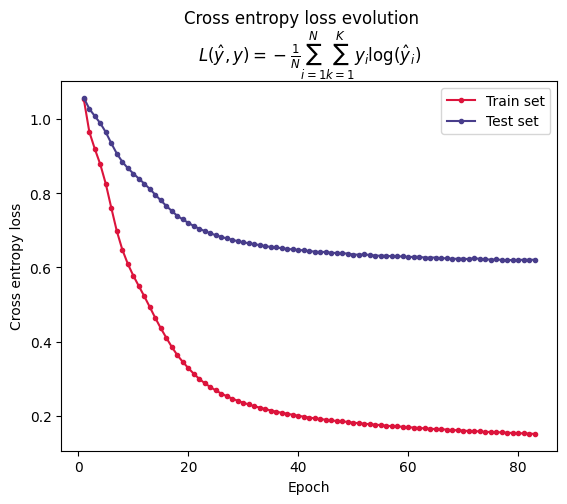

In [24]:
loss_module = nn.CrossEntropyLoss()
model = MlpModel(num_inputs=X_train.shape[1], num_hidden=10, num_outputs=len(np.unique(y_train)), num_layers=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
dev_data_loader = data.DataLoader(dev_dataset, batch_size=1, shuffle=False, drop_last=False)

classfier = MlpClassifier(model, optimizer, loss_module)
train_losses, test_losses = classfier.train_model(train_data_loader, dev_data_loader)

Curve.cross_entropy_loss_curve(train_losses, test_losses)

In [25]:
train_data_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=False, drop_last=False)
_, y_custom = classfier.eval_model(train_data_loader)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8546
           1       0.96      0.89      0.93      2711
           2       0.94      0.99      0.97      3143

    accuracy                           0.96     14400
   macro avg       0.96      0.95      0.95     14400
weighted avg       0.96      0.96      0.96     14400



In [26]:
test_data_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
_, y_custom = classfier.eval_model(test_data_loader)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2344
           1       0.97      0.91      0.94       785
           2       0.92      1.00      0.96       871

    accuracy                           0.96      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.96      0.96      0.96      4000



In [29]:
print(model)

MlpModel(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


### Scikit-Learn MLP

sklearn.neural_network.MLPClassifier

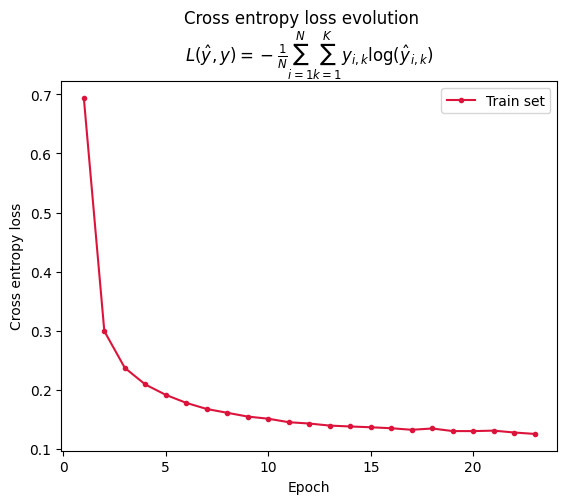

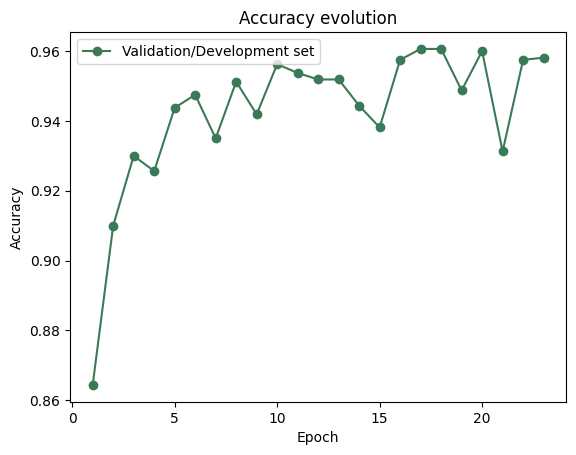

17

In [73]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=[10,10], activation='relu', solver='sgd', batch_size=128, alpha=0, max_iter=100, shuffle=True, learning_rate_init=0.01, n_iter_no_change=5, early_stopping=True, validation_fraction=0.1)
mlp.fit(np.concatenate((X_train,X_dev), axis=0), np.concatenate((y_train, y_dev), axis=0))

Curve.cross_entropy_loss_curve(mlp.loss_curve_)
Curve.accuracy_evolution_curve("Epoch", mlp.validation_scores_, "Validation/Development set")

In [27]:
y_scikit = mlp.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8546
           1       0.96      0.91      0.93      2711
           2       0.95      1.00      0.97      3143

    accuracy                           0.96     14400
   macro avg       0.96      0.96      0.96     14400
weighted avg       0.96      0.96      0.96     14400



In [28]:
y_scikit = mlp.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2344
           1       0.96      0.91      0.94       785
           2       0.90      1.00      0.95       871

    accuracy                           0.95      4000
   macro avg       0.94      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000

